# Modello convolutivo di base - Dataset rumore
In precedenza abbiamo visto l'addestramento del nostro modello convolutivo di base sul dataset originale, e dopodiché abbiamo parlato della data augmentation.

AGGIORNARE

Come al solito, implementiamo le librerie funzioni necessarie. Inoltre otteniamo il nuovo dataset attraverso le tecniche viste nel notebook relativo alla data augmentation.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import scipy.fftpack as scipy
import random
import os
import time
# per il modello con estensione .onnx
import onnxruntime as rt
import tf2onnx
import onnx

## Classe per la conversione del dataset
Questa classe l'abbiamo già vista implementata nel notebook riguardante l'addestramento dei filterbanks e degli mfcc.

In [2]:
class DatasetConverter:
    def __init__(self, dataset):
        self.dataset = dataset

    def convert(self, option):
        available_options = ['spettrogrammi', 'filterbanks', 'mfcc']
        
        if option == available_options[0]:
            return self.get_spectrogram_dataset()
        elif option == available_options[1]:
            return self.get_filterbanks_dataset()
        elif option == available_options[2]:
            return self.get_mfcc_dataset()
        else:
            raise ValueError(f"Opzione non disponibile: inserire una delle seguenti opzioni: {available_options}")
    
    # INIZIO SPETTROGRAMMI
    def squeeze(self, audio, labels):
        audio = tf.squeeze(audio, axis=-1)
        return audio, labels
    
    def get_spectrogram(self, waveform):
    # applichiamo la short-time Fourier transorm
        spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
        spectrogram = tf.abs(spectrogram)
        
        return spectrogram[..., tf.newaxis]
    
    def get_spectrogram_dataset(self):
        # squeeze
        self.dataset = self.dataset.map(self.squeeze, tf.data.AUTOTUNE)
        self.dataset = self.dataset.map(lambda x, y: (self.get_spectrogram(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        
        return self.dataset

    # FINE SPETTROGRAMMI

    def convert_to_numpy(self, dataset):
        audio_data = []
        labels = []
    
        dataset = dataset.unbatch()
        
        for audio, label in dataset:
            audio_data.append(audio.numpy())  # Assuming audio is a tensor, convert to numpy array
            labels.append(label.numpy())      # Assuming label is a tensor, convert to numpy array
        
        audio_data = np.array(audio_data)
        labels = np.array(labels)
        
        return audio_data, labels
    
    # INIZIO FILTERBANKS
    def makeHamming(self, M):
        R = (( M - 1 ) / 2 , M / 2)[M % 2 == 0]
        w = (np.hamming(M), np.hamming(M + 1))[M % 2 == 0]
        if M % 2 != 0:
            w[0] = w[0]/2
            w[M-1] = w[M-1]/2
        else:
            w = w[:M]
    
        return w

    def hztomel(self, hz):
        return (2595 * np.log10(1 + hz / 700))

    def meltohz(self, mel):
        return (700 * (10**(mel / 2595) - 1))

    def compute_filterbanks(self, audios_np, pre_emphasis=0.97, sample_rate=16000, frame_size=0.025, frame_stride=0.01, NFFT=512, nfilt=40):
        filterbanks_np = []
        
        for samples in audios_np:
            emphasized_audio = np.append(samples[0], samples[1:] - pre_emphasis * samples[:-1])
            audio_length = len(emphasized_audio)
    
            frame_length, frame_step = int(frame_size * sample_rate), int(frame_stride * sample_rate)
    
            num_frames = int(np.ceil(float(np.abs(audio_length - frame_length)) / frame_step))
    
            pad_audio_length = num_frames * frame_step + frame_length
            z = np.zeros((pad_audio_length - audio_length))
            pad_audio = np.append(emphasized_audio, z)
    
            indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
            frames = pad_audio[indices.astype(np.int32, copy=False)]
    
            # Usiamo la funzione di Hamming
            hamming_window = self.makeHamming(frame_length)
    
            mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitudo della FFT
            pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))
    
            # convertiamo hz in mel
            low_freq_mel = self.hztomel(0)
            high_freq_mel = self.hztomel(sample_rate / 2)
    
            mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
            hz_points = self.meltohz(mel_points) 
    
            bin = np.floor((NFFT + 1) * hz_points / sample_rate)
    
            fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    
            for m in range(1, nfilt + 1):
                f_m_minus = int(bin[m - 1])
                f_m = int(bin[m])
                f_m_plus = int(bin[m + 1])
    
                for k in range(f_m_minus, f_m):
                    fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
                for k in range(f_m, f_m_plus):
                    fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    
            # in questo momento invece calcoliamo i filter banks per i segmenti di audio, utilizzando i filtri triangolari appena creati
            filter_banks = np.dot(pow_frames, fbank.T)
            filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
            filter_banks = 20 * np.log10(filter_banks)
    
            filterbanks_np.append(filter_banks)
        
        return np.array(filterbanks_np)
    
    def get_filterbanks_dataset(self): 
        audios, labels = self.convert_to_numpy(self.dataset)

        filterbanks = self.compute_filterbanks(audios)
        filterbanks = np.expand_dims(filterbanks, axis=-1)

        self.dataset = tf.data.Dataset.from_tensor_slices((filterbanks, labels))
        self.dataset = self.dataset.batch(32)
        
        return self.dataset
    # FINE FILTERBANKS

    # INIZIO MFCC
    def compute_mfcc(self, filter_banks, num_ceps=12, cep_lifter=22):
        mfcc_np = []
        
        for f in filter_banks:
            mfcc = scipy.dct(f, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]

            (nframes, ncoeff) = mfcc.shape
            n = np.arange(ncoeff)
            
            lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
            mfcc *= lift

            mfcc_np.append(mfcc)
        
        return np.array(mfcc_np)
    
    
    def get_mfcc_dataset(self):
        audios, labels = self.convert_to_numpy(self.dataset)

        filterbanks = self.compute_filterbanks(audios)
        mfcc = self.compute_mfcc(filterbanks)
        
        mfcc = np.expand_dims(mfcc, axis=-1)
        
        self.dataset = tf.data.Dataset.from_tensor_slices((mfcc, labels))
        self.dataset = self.dataset.batch(32)
        
        return self.dataset
    
    # FINE MFCC

## Importazione funzioni ulteriori
In aggiunta alla classe per la conversione del dataset, ci serviremo delle seguenti funzioni: 
- `convert_history_to_csv` - salva l'history dell'addestramento in un csv
- `convert_model_to_onnx` - converte il miglior modello **.keras** in **.onnx**
- `create_train_val_plot` - visualizza l'andamento dell'accuratezza e della perdita durante l'addestramento
- `evaluate_onnx_model` - valuta il modello sui dati di test con il modello **.onnx**
- `create_distribution_plot` - visualizza la distribuzione di accuratezza delle classi su un'immagine casuale

Anch'esse sono già state viste, perciò non ci soffermeremo troppo su di esse.

In [3]:
def convert_history_to_csv(model_history):
    # converto la history del dataframe in un dataframe pandas
    model_history_df = pd.DataFrame(model_history.history)
    # cambio il nome dell'indice e lo imposto a partire da 1
    model_history_df.index = range(1, len(model_history_df) + 1)
    model_history_df.index.name = "epochs"

    return model_history_df

def convert_model_to_onnx(model_path, input_shape):
    model = tf.keras.models.load_model(model_path)

    onnx_path = model_path.split(".")[:-1] + ["onnx"]
    onnx_path = ".".join(onnx_path)
    
    input_signature = [tf.TensorSpec((None, *input_shape), tf.float32, name="input")]
    onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=input_signature)

    onnx.save(onnx_model, onnx_path)

def create_train_val_plot(history, overfit=True):
    # definisco numero epoche
    epochs = range(1, len(history['accuracy']) + 1)

    # Accuracy
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    fig_acc, ax_acc = plt.subplots()

    # linea di base
    ax_acc.plot(epochs, [0.5 for x in range(len(epochs))], color="lightgray", linestyle="--", label="Base")
    # linee di accuratezza
    ax_acc.plot(epochs, accuracy, color="slategray", label="Accuratezza in addestramento")
    ax_acc.plot(epochs, val_accuracy, color="indianred", label="Accuratezza in validazione")
    # miglior accuratezza validazione
    ax_acc.axhline(y=max(val_accuracy), c='indianred', alpha=0.7, linestyle='--')
    ax_acc.text(len(epochs) * 1.07, max(val_accuracy), round(max(val_accuracy), 2), fontsize=9, fontweight="bold", horizontalalignment="left", verticalalignment="center")
    # nascondo limiti plot
    ax_acc.spines["right"].set_visible(False)
    ax_acc.spines["top"].set_visible(False)
    ax_acc.spines["left"].set_visible(False)
    # definizione label e titolo + legenda
    ax_acc.set_title("Accuratezza in addestramento e validazione")
    ax_acc.set_xlabel("Epoche")
    ax_acc.set_ylabel("Accuratezza (%)")
    ax_acc.legend()

    # Loss
    loss = history['loss']
    val_loss = history['val_loss']

    fig_loss, ax_loss = plt.subplots()

    # linee di loss
    ax_loss.plot(epochs, loss, color="slategray", label="Perdita in addestramento")
    ax_loss.plot(epochs, val_loss, color="indianred", label="Perdita in validazione")
    # miglior loss validazione
    ax_loss.axhline(y=min(val_loss), c='indianred', alpha=0.7, linestyle='--')
    ax_loss.text(len(epochs) * 1.07, min(val_loss), round(min(val_loss), 2), fontsize=9, fontweight="bold", horizontalalignment="left", verticalalignment="center")
    # nascondo limiti plot
    ax_loss.spines["right"].set_visible(False)
    ax_loss.spines["top"].set_visible(False)
    ax_loss.spines["left"].set_visible(False)
    # definizione label e titolo + legenda
    ax_loss.set_title("Perdita in addestramento e validazione")
    ax_loss.set_xlabel("Epoche")
    ax_loss.set_ylabel("Perdita")

    handles, _ = ax_loss.get_legend_handles_labels()

    if overfit:
        # area overfit
        rect = mpatches.Rectangle((np.argmin(val_loss) + 1, 0), width=100 - np.argmin(val_loss), height=max(max(loss), max(val_loss)), color='lightcoral', alpha=0.3)
        ax_loss.add_patch(rect)
        # patch overfit per legenda
        overfit = mpatches.Patch(color='indianred', alpha=0.3, label='Area overfit')
        handles, _ = ax_loss.get_legend_handles_labels()
        handles.append(overfit)

    # legenda
    ax_loss.legend(handles=handles)

    plt.show()

def evaluate_onnx_model(path_model_onnx, test_ds):
    # il fatto che sia suddiviso in batch mi crea problemi, perciò lo risolvo togliendoli
    test_ds = test_ds.unbatch()
    
    # carico il modello utilizzando il file onnx
    m = rt.InferenceSession(path_model_onnx)
    
    # trasformo il dataset in array numpy
    spectrogram_np = np.array([spectrogram.numpy() for spectrogram, _ in test_ds], dtype=np.float32)
    labels_np = np.array([label.numpy() for _, label in test_ds])
    
    # eseguo le predizione del modello
    pred_onnx = m.run(None, {'input': spectrogram_np})
    # ottengo la predizione corretta
    predictions = np.argmax(pred_onnx[0], axis=1)
    # computo la accuratezza
    accuracy = np.mean(predictions == labels_np)
    # stampo l'accuratezza
    print(f"Accuratezza: {accuracy:.3f}")

def create_distribution_plot(model, audio, label):
    label_names = audio_label_names
    
    prediction = model(audio) # otteniamo la predizione del modello sull'audio preso in input

    random_audio_index = np.random.randint(0, len(prediction) - 1) # abbiamo notato che mostravamo sempre la classe no, magari così cambia un po' le classi che mostriamo

    softmax_pred = tf.nn.softmax(prediction[random_audio_index]) # dobbiamo applicare nuovamente la softmax in modo tale da avere dei dati leggibili
    pred_label = np.argmax(softmax_pred) # ci salviamo l'indice della label predetta dal nostro modello, quella con la probabilità più alta

    colors = ['indianred'] * len(label_names) # creiamo un vettore di lunghezza 30 (la quantità delle nostre label) colorate di rosso

    if pred_label == label[random_audio_index].numpy(): # se la label che abbiamo predetto è corretta, allora la coloriamo di verde
        colors[pred_label] = 'seagreen'
    else: # se la label che abbiamo predetto è sbagliata, allora coloriamo di verde la corretta e di gialla la predetta
        colors[pred_label] = 'khaki'
        colors[label[random_audio_index].numpy()] = 'seagreen'

    plt.figure(figsize=(12, 4))
    
    plt.bar(label_names, softmax_pred.numpy(), color=colors)
    plt.xticks(rotation=45)

    # dichiariamo i colori della legenda
    other_values_patch = mpatches.Patch(color='indianred', label='Altre classi')
    pred_value_patch = mpatches.Patch(color='khaki', label='Classe predetta')
    correct_value_patch = mpatches.Patch(color='green', label='Classe corretta')

    # disegniamo la legenda con i colori necessari
    if pred_label == label[random_audio_index].numpy(): # se abbiamo predetto correttamente la label, non è necessario mostrare il colore giallo (non è presente nel plot)
        plt.legend(handles=[other_values_patch, correct_value_patch])
    else:
        plt.legend(handles=[other_values_patch, pred_value_patch, correct_value_patch])

    plt.show()

In [4]:
train_ds, validation_ds = tf.keras.utils.audio_dataset_from_directory(
    directory ='../reduced_dataset/dataset/audio',
    validation_split=0.4, # stiamo mettendo da parte il 40% del dataset, che sarà suddiviso in validation set e test set
    shuffle=True,
    subset='both', # necessario se stiamo utilizzando validation_split
    seed=0 # necessario se stiamo utilizzando sia shuffle che validation_split 
)
audio_label_names = train_ds.class_names

noise_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='../noise_dataset',
    batch_size = 1
)

noise_label_names = noise_ds.class_names

Found 12933 files belonging to 30 classes.
Using 7760 files for training.
Using 5173 files for validation.
Found 14 files belonging to 14 classes.


## Applicazione tecniche data augmentation
Abbiamo già visto l'utilizzo delle tecniche che andremo a applicare in questo momento, perciò non ci soffermeremo sulla loro spiegazione ma descriveremo i passaggi molto sinteticamnete.

Tagliamo gli audio del dataset rumoroso.

In [5]:
def cut_audios(dataset, length):
    new_audios = [] # inizializziamo una lista dove inseriremo i nostri audio tagliati
    labels = []
    
    # iteriamo nel dataset
    for audio, label in dataset:
        # tagliamo l'audio ad un secondo e lo appendiamo a una lista 
        labels.append(label.numpy())
        
        audio = tf.reshape(audio, [-1])[np.shape(audio)[1]//2:np.shape(audio)[1]//2 + length]
        new_audios.append(audio.numpy()) # convertiamo in array per poterli modificare
        
    return new_audios, labels

cut_noise_audios, cut_noise_labels = cut_audios(noise_ds, 16000)

Creiamo il nuovo dataset, unendo l'originale con quello rumoroso. L'output che otteneremo è una lista.

In [6]:
def mix_audios(original_audios, noise_audios):
    mixed_dataset = [] # inizializziamo la lista dove inseriremo gli audio uniti al rumore

    original_audios = original_audios.unbatch() # il nostro training set ha una batch_size di 32, per rendere il processo più semplice unbatchiamo
    
    # per ogni audio del dataset originale
    for audio, label in original_audios:    
        audio = np.squeeze(audio, axis=-1) # rimuoviamo l'ultima asse inutile (quella dei canali)
        
        # Scegliamo in modo randomico un audio dalla lista degli audio rumorosi
        noise_sample = random.choice(noise_audios)

        # calcolo l'ampiezza massima dell'audio rumoroso
        max_amplitude_audio = np.max(np.abs(audio))
        max_amplitude_noise = np.max(np.abs(noise_sample))
        # calcolo un noise factor che varia a seconda dell'ampiezza massima di entrambi gli audio
        noise_factor = max_amplitude_audio / max_amplitude_noise
        noise_factor = min(noise_factor, 1.0)
        
        noise_sample = noise_sample * noise_factor
        
        mixed_audio = audio + noise_sample # uniamo l'audio original al rumore

        # aggiungiamo l'audio con noise alla lista
        mixed_dataset.append((mixed_audio, label))

    return mixed_dataset

mixed_train_list = mix_audios(train_ds, cut_noise_audios)
mixed_val_list = mix_audios(validation_ds, cut_noise_audios)

Convertiamo la lista in un dataset di tensori.

In [7]:
def create_mixed_ds(dataset_list):
    audio_data = [tf.convert_to_tensor(audio, dtype=tf.float32) for audio, label in dataset_list]
    labels = [label for _, label in dataset_list]

    audio_data = tf.expand_dims(audio_data, axis=-1)
    
    mixed_train_ds = tf.data.Dataset.from_tensor_slices((audio_data, labels))
    mixed_train_ds = mixed_train_ds.batch(32)
    return mixed_train_ds

mixed_train_ds = create_mixed_ds(mixed_train_list)
mixed_validation_ds = create_mixed_ds(mixed_val_list)

## Suddivisione dataset
Ottenuto il dataset rumoroso possiamo procedere a convertirlo e suddividerlo.

In [8]:
spect_mixed_train_ds = DatasetConverter(mixed_train_ds)
spect_mixed_train_ds = spect_mixed_train_ds.convert("spettrogrammi")

spect_mixed_validation_ds = DatasetConverter(mixed_validation_ds)
spect_mixed_validation_ds = spect_mixed_validation_ds.convert("spettrogrammi")

spect_mixed_val_ds = spect_mixed_validation_ds.take(spect_mixed_validation_ds.cardinality() // 2) # ho cambiato nome del validation_ds in modo tale da non creare problemi con l'istruzione seguente
spect_mixed_test_ds = spect_mixed_validation_ds.skip(spect_mixed_validation_ds.cardinality() // 2)

Adesso siamo pronti per addestrare i modelli su un dataset rumoroso.

## Addestramento (spettrogrammi)
Come già detto, le reti neurali convolutive che andremo a trattare sono le stesse presenti nel notebook del modello convolutivo base. Stiamo addestrando gli stessi modelli in modo da poter confrontare le loro prestazioni in un notebook a parte.

Iniziamo con il primo modello base.

In [9]:
def get_basic_model(input_shape):
    # Dichiariamo lo shape dell'input, ridimensioniamo le immagini, e normalizziamo
    inputs = tf.keras.Input(shape=input_shape, name="inputs")
    x = tf.keras.layers.Normalization(name="normalizzazione")(inputs)

    # Blocco di apprendimento delle caratteristiche
    conv2D_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same", name="conv2D_1")(x)
    MaxPooling2D_1 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_1")(conv2D_1)
    conv2D_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same", name="conv2D_2")(MaxPooling2D_1)
    MaxPooling2D_2 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_2")(conv2D_2)
    conv2D_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same", name="conv2D_3")(MaxPooling2D_2)
    MaxPooling2D_3 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_3")(conv2D_3)
    conv2D_4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same", name="conv2D_4")(MaxPooling2D_3)
    MaxPooling2D_4 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_4")(conv2D_4)
    conv2D_5 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same", name="conv2D_5")(MaxPooling2D_4)

    # Blocco di classificazione
    Flatten = tf.keras.layers.Flatten(name="Flatten")(conv2D_5)
    outputs = tf.keras.layers.Dense(30, activation="softmax", name="dense_output")(Flatten)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [10]:
for audio, label in spect_mixed_train_ds:
    basic_model = get_basic_model(audio.shape[1:])
    break

basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/noise/adam/spectrogram/basic_model.keras", save_best_only=True, monitor="val_loss")]
basic_model_history = basic_model.fit(spect_mixed_train_ds, epochs=30, validation_data=spect_mixed_val_ds, callbacks=basic_model_callbacks)

Epoch 1/30
243/243 [==============================] - 9s 12ms/step - loss: 2.9413 - accuracy: 0.1601 - val_loss: 2.3631 - val_accuracy: 0.3063
Epoch 2/30
243/243 [==============================] - 3s 11ms/step - loss: 1.9101 - accuracy: 0.4534 - val_loss: 1.7153 - val_accuracy: 0.5301
Epoch 3/30
243/243 [==============================] - 3s 10ms/step - loss: 1.2017 - accuracy: 0.6463 - val_loss: 1.4357 - val_accuracy: 0.6119
Epoch 4/30
243/243 [==============================] - 3s 10ms/step - loss: 0.8464 - accuracy: 0.7428 - val_loss: 1.2787 - val_accuracy: 0.6539
Epoch 5/30
243/243 [==============================] - 3s 11ms/step - loss: 0.6295 - accuracy: 0.8079 - val_loss: 1.3167 - val_accuracy: 0.6644
Epoch 6/30
243/243 [==============================] - 3s 11ms/step - loss: 0.4930 - accuracy: 0.8517 - val_loss: 1.4923 - val_accuracy: 0.6933
Epoch 7/30
243/243 [==============================] - 3s 11ms/step - loss: 0.3954 - accuracy: 0.8831 - val_loss: 1.5257 - val_accuracy: 0.6968

Salviamo i dati della history del modello in un file csv

In [11]:
basic_model_history_df = convert_history_to_csv(basic_model_history)
basic_model_history_df.to_csv("model_histories/noise/adam/spectrogram/basic_model_history.csv")

Salviamo il miglior modello come file csv nella seguente directory `model_histories/noise/adam/` con il nome `basic_model_history`. Inoltre, per prevenire errori di salvataggio causati da versioni differenti di python o dei pacchetti, procediamo con la conversione del file in formato standard `.onnx`.

In [12]:
convert_model_to_onnx("bestmodels/noise/adam/spectrogram/basic_model.keras", (124, 129, 1))

Utilizziamo la funzione `create_train_val_plot` per mostrare l'andamento dell'accurateza e della perdita durante l'addestramento.

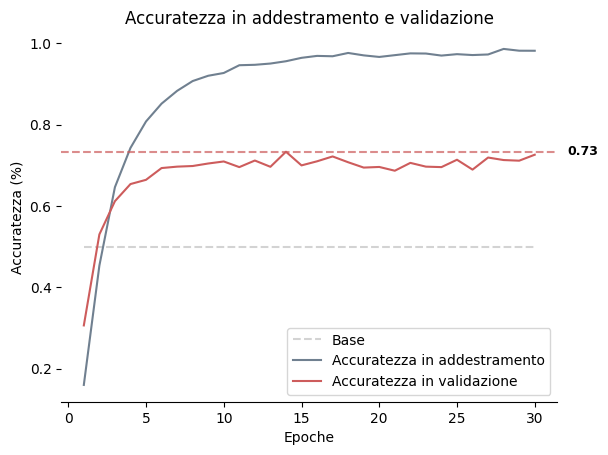

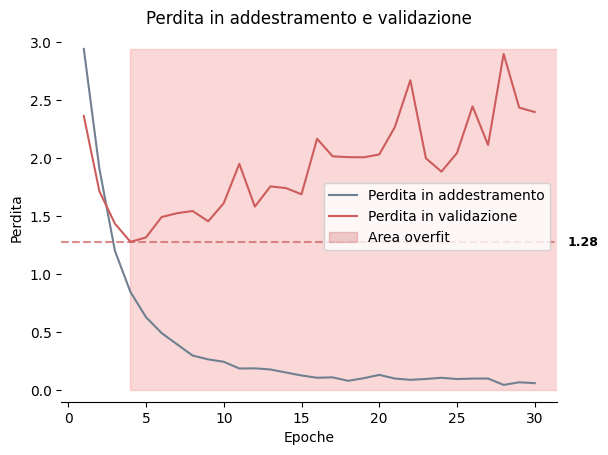

In [13]:
create_train_val_plot(basic_model_history.history)

Questi grafici mostrano come il nostro modello sia andato immediatamente in overfitting. L'accuratezza dell'addestramento aumenta col tempo e raggiunge quasi il **100%**, mentre l'accuratezza della validazione si attesta sull'**75%**. La **perdita nel set di addestramento** continua a diminuire dopo la **quinta epoca**, mentre la **perdita nel set di validazione** aumenta.

Non siamo riusciti a raggiungere una buona accuratezza nella validazione.

Possiamo verificare l'accuratezza della migliore versione del nostro modello di base ricaricando il file **basic_model.keras**

In [14]:
best_basic_model = tf.keras.models.load_model("bestmodels/noise/adam/spectrogram/basic_model.keras")
test_loss, test_acc = best_basic_model.evaluate(spect_mixed_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 1s 5ms/step - loss: 1.3056 - accuracy: 0.6486
Accuratezza: 0.649


In [15]:
evaluate_onnx_model("bestmodels/noise/adam/spectrogram/basic_model.onnx", spect_mixed_test_ds)

Accuratezza: 0.649


Abbiamo ottenuto un'**accuratezza** del **64.9%**, possiamo già notare un peggioramento notevole. Visualizziamo la distribuzione di accuratezza delle classi su un'immagine casuale.

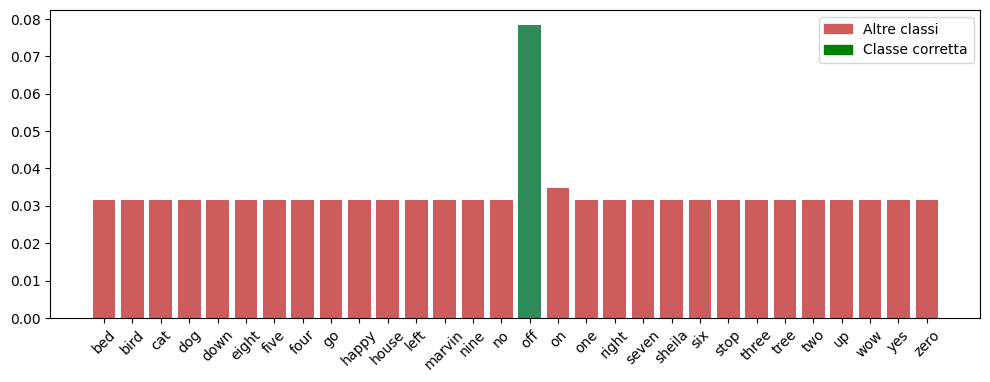

In [16]:
for audio, label in spect_mixed_test_ds: # prendiamo un audio a caso del test e creiamo la distribuzione
    create_distribution_plot(best_basic_model, audio, label)
    break

### Risoluzione dell'overfitting
Il modello è andato immediatamente in **overfitting**, e lo possiamo notare dalla loss di validazione che inizia a salire dalla quinta epoca in poi. Cercheremo di ritardarla leggermente seguendo le stesse procedure del notebook di riferimento.

In [17]:
def get_improved_basic_model(input_shape):
    # Dichiariamo lo shape dell'input, ridimensioniamo le immagini, e normalizziamo
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Normalization()(inputs)

    # Blocco di apprendimento delle caratteristiche
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

    # Blocco di classificazione
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [18]:
for audio, label in spect_mixed_train_ds:
    improved_basic_model = get_improved_basic_model(audio.shape[1:])
    break

improved_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [19]:
improved_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/noise/adam/spectrogram/improved_basic_model.keras", save_best_only=True, monitor="val_loss")]
improved_history = improved_basic_model.fit(spect_mixed_train_ds, epochs=100, validation_data=spect_mixed_val_ds, callbacks=improved_basic_model_callbacks)

Epoch 1/100
243/243 [==============================] - 4s 13ms/step - loss: 3.0349 - accuracy: 0.1399 - val_loss: 2.5813 - val_accuracy: 0.2465
Epoch 2/100
243/243 [==============================] - 3s 12ms/step - loss: 2.1651 - accuracy: 0.3742 - val_loss: 1.8218 - val_accuracy: 0.4726
Epoch 3/100
243/243 [==============================] - 3s 10ms/step - loss: 1.5210 - accuracy: 0.5506 - val_loss: 1.4716 - val_accuracy: 0.5864
Epoch 4/100
243/243 [==============================] - 3s 10ms/step - loss: 1.1406 - accuracy: 0.6577 - val_loss: 1.2631 - val_accuracy: 0.6331
Epoch 5/100
243/243 [==============================] - 3s 10ms/step - loss: 0.8846 - accuracy: 0.7352 - val_loss: 1.1399 - val_accuracy: 0.6628
Epoch 6/100
243/243 [==============================] - 3s 10ms/step - loss: 0.7289 - accuracy: 0.7747 - val_loss: 1.1778 - val_accuracy: 0.6856
Epoch 7/100
243/243 [==============================] - 3s 10ms/step - loss: 0.6010 - accuracy: 0.8121 - val_loss: 1.2270 - val_accuracy:

Salviamo come prima la history del modello in un file csv, e convertiamo il miglior modello nel formato **.onnx**.

In [20]:
improved_history_df = convert_history_to_csv(improved_history)
improved_history_df.to_csv("model_histories/noise/adam/spectrogram/improved_history.csv")

convert_model_to_onnx("bestmodels/noise/adam/spectrogram/improved_basic_model.keras", (124, 129, 1))

Visualizziamo la curva dell'accuratezza e della perdita durante l'addestramento.

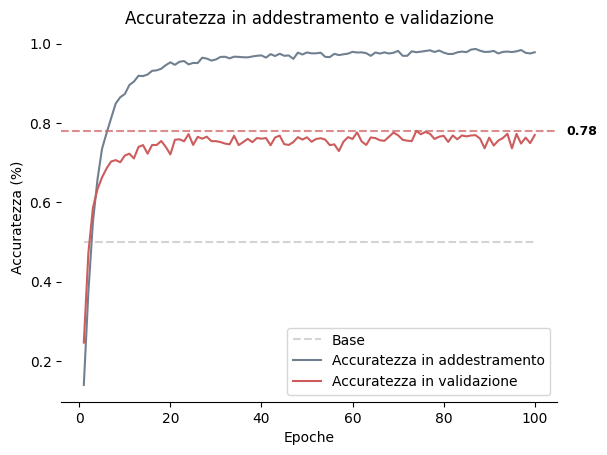

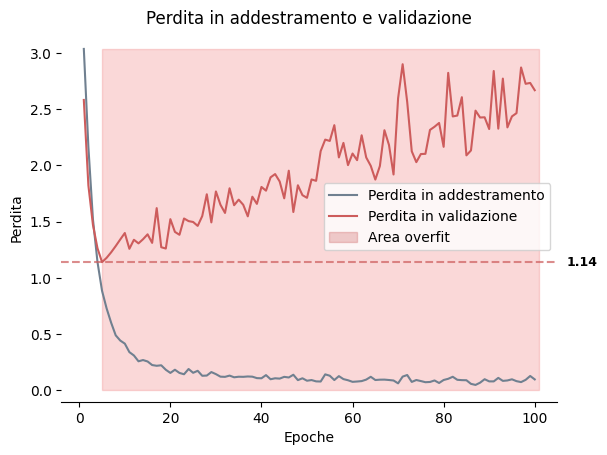

In [21]:
create_train_val_plot(improved_history.history)

Le prestazioni sono leggermente migliorate rispetto all'applicazione precedente. Verifichiamo l'accuratezza nel dataset di test.

In [22]:
improved_best_model = tf.keras.models.load_model("bestmodels/noise/adam/spectrogram/improved_basic_model.keras")
test_loss, test_acc = improved_best_model.evaluate(spect_mixed_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 1s 4ms/step - loss: 1.1606 - accuracy: 0.6656
Accuratezza: 0.666


In [23]:
evaluate_onnx_model("bestmodels/noise/adam/spectrogram/improved_basic_model.onnx", spect_mixed_test_ds)

Accuratezza: 0.666


Abbiamo ottenuto un notevole miglioramento dell'accuratezza, attualmente siamo a quota **70.1%**! Visualizziamo anche la solita distribuzione.

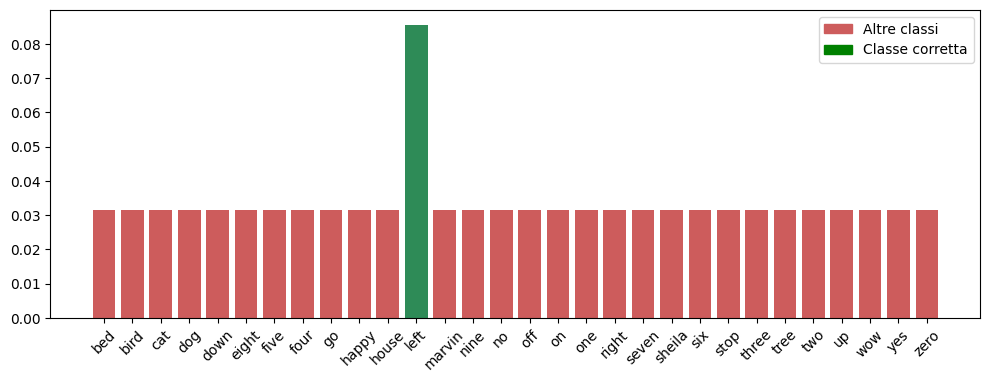

In [24]:
for audio, label in spect_mixed_test_ds:
    create_distribution_plot(improved_best_model, audio, label)
    break

### Fine tuning
In questa sezione andremo a effettuare il fine tuning del modello convolutivo con la stessa metodologia del notebook di riferimento.

Per ora non abbiamo ottenuto delle buone prestazioni, la validazione non riesce a perciò proveremo a aumentare, bloccandosi troppo presto. Cerchiamo di capire attraverso le funzioni `tuner` e `plot_models` qual è il problema.

In [25]:
def get_improved_basic_model_tuning(start_filters):
    # Dichiariamo lo shape dell'input, ridimensioniamo le immagini, e normalizziamo
    inputs = tf.keras.Input(shape=(124, 129, 1))
    x = tf.keras.layers.Normalization()(inputs)

    if not isinstance(start_filters, int):
        raise Exception("start_filters must be type integer")

    filters = [start_filters * (2 ** i) for i in range(4)]
    
    # Blocco di apprendimento delle caratteristiche
    x = tf.keras.layers.Conv2D(filters=filters[0], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=filters[1], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=filters[2], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=filters[3], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=filters[3], kernel_size=3, activation="relu", padding="same")(x)

    # Blocco di classificazione
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

def tuner(filters, learning_rates, max_epochs, train_dataset, validation_dataset):
    start_time = time.time()

    counter = 1
    
    if not isinstance(filters, list):
        raise Exception("parameter filters must be type list")

    if not isinstance(learning_rates, list):
        raise Exception("parameter learning_rates must be type list")

    callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]

    best_learning_rate = 0 
    best_filters = 0
    best_val_accuracy = 0

    best_model = 0
    
    for f in filters:
        for lr in learning_rates:
            print(f"\nAddestrando con filtri {[f * (2 ** i) for i in range(4)]} e tasso di apprendimento {lr}")
            
            model = get_improved_basic_model_tuning(start_filters=f)
            model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=["accuracy"])
            model_history = model.fit(train_dataset, epochs=max_epochs, validation_data=validation_dataset, callbacks=callbacks)

            model_history_df = convert_history_to_csv(model_history)

            model_history_df[["filters"]] = f
            model_history_df[["learning_rate"]] = lr
            
            path = "model_tuning/noise/adam/spectrogram/model_" + str(counter) + ".csv"
            model_history_df.to_csv(path)
            
            if best_val_accuracy < model_history_df.iloc[-1]["val_accuracy"]:
                best_val_accuracy = model_history_df.iloc[-1]["val_accuracy"]
                best_filters = f
                best_learning_rate = lr
                epoch = len(model_history_df)

            del model

            counter += 1

    total_time = time.time() - start_time
    minutes, seconds = divmod(total_time, 60)
    print(f"\nTempo totale trascorso: {int(minutes)} minuti e {int(seconds)} secondi")
    # print(f"Il miglior modello ha un filtro di partenza pari a {best_filters}, un learning rate pari a {best_learning_rate} con un'accuracy pari a {best_val_accuracy:.3f}")

    return best_filters, best_learning_rate

best_filter, best_learning_rate = tuner([16, 32, 64], [1e-3, 1e-4, 1e-5], 30, spect_mixed_train_ds, spect_mixed_val_ds)


Addestrando con filtri [16, 32, 64, 128] e tasso di apprendimento 0.001
Epoch 1/30
243/243 [==============================] - 2s 7ms/step - loss: 3.0975 - accuracy: 0.1237 - val_loss: 2.6021 - val_accuracy: 0.2446
Epoch 2/30
243/243 [==============================] - 2s 6ms/step - loss: 2.2879 - accuracy: 0.3345 - val_loss: 2.0263 - val_accuracy: 0.4545
Epoch 3/30
243/243 [==============================] - 2s 7ms/step - loss: 1.6338 - accuracy: 0.5211 - val_loss: 1.5480 - val_accuracy: 0.5737
Epoch 4/30
243/243 [==============================] - 2s 6ms/step - loss: 1.2719 - accuracy: 0.6236 - val_loss: 1.2862 - val_accuracy: 0.6362
Epoch 5/30
243/243 [==============================] - 2s 6ms/step - loss: 1.0359 - accuracy: 0.6952 - val_loss: 1.1980 - val_accuracy: 0.6454
Epoch 6/30
243/243 [==============================] - 2s 6ms/step - loss: 0.8613 - accuracy: 0.7403 - val_loss: 1.0762 - val_accuracy: 0.6979
Epoch 7/30
243/243 [==============================] - 2s 6ms/step - loss: 0

Il tempo necessario per la ricerca dei migliori iperparametri è stata di **9 minuti e 41
secondi**.

Definiamo e utilizziamo la funzione `plot_models` per visualizzare l'accuratezza e la perdita di tutti i modelli che il tuner ha addestrato.

In [26]:
def plot_models(path, reverse=False, show="accuracy", overfit=True):
    n_models = len(os.listdir(path))
    # creo il subplot a seconda di quanti modelli dispongo
    best_pair = None
    min_diff = float("inf")
    
    for idx_model in range(1, int(np.sqrt(n_models)) + 1):
        if n_models % idx_model == 0:
            diff = abs(idx_model - n_models // idx_model)

            if diff < min_diff:
                min_diff = diff
                best_pair = (idx_model, n_models // idx_model)

    if reverse:
        rows = best_pair[1]
        cols = best_pair[0]
    else:
        rows = best_pair[0]
        cols = best_pair[1]
    
    fig, axes = plt.subplots(rows, cols, figsize=(14, 10))
    
    for index, model in enumerate(os.listdir(path)):
        row = index // cols
        col = index % cols
    
        ax = axes[row][col]
        
        newpath = path + "/" + model
        df = pd.read_csv(newpath)

        value1 = df[show].values
        value2 = df["val_" + show].values
        
        ax.plot(range(1, len(value1) + 1), value1, color="slategray", label="Addestramento")
        ax.plot(range(1, len(value2) + 1), value2, color="indianred", label="Validazione")

        if (row in range(rows)) and col == 0:
            ax.set_ylabel("Accuratezza (%)" if show == "accuracy" else "Perdita", fontweight="semibold", fontsize=10)

        if (col in range(cols)) and row == 2:
            ax.set_xlabel("Epoche", fontweight="semibold", fontsize=10)

        ax.set_title("Filtro " + str(df["filters"][0]) + " & lr " + str(df["learning_rate"][0]), fontsize=12)
            
        ax.set_ylim(0)
        ax.set_xlim(0)

        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        ax.grid(True, color="gainsboro", alpha=0.3, linestyle="--")

        handles, _ = ax.get_legend_handles_labels()
        
        if overfit and show == "loss":
            # area overfit
            
            rect = mpatches.Rectangle((np.argmin(value2) + 1, 0), width=len(value1) - np.argmin(value2), height=max(max(value1), max(value2)), color='lightcoral', alpha=0.3)
            ax.add_patch(rect)
            # patch overfit per legenda
            overfit = mpatches.Patch(color='lightcoral', alpha=0.3, label='Area overfit')
           
            handles.append(overfit)

        ax.legend(handles=handles)

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()

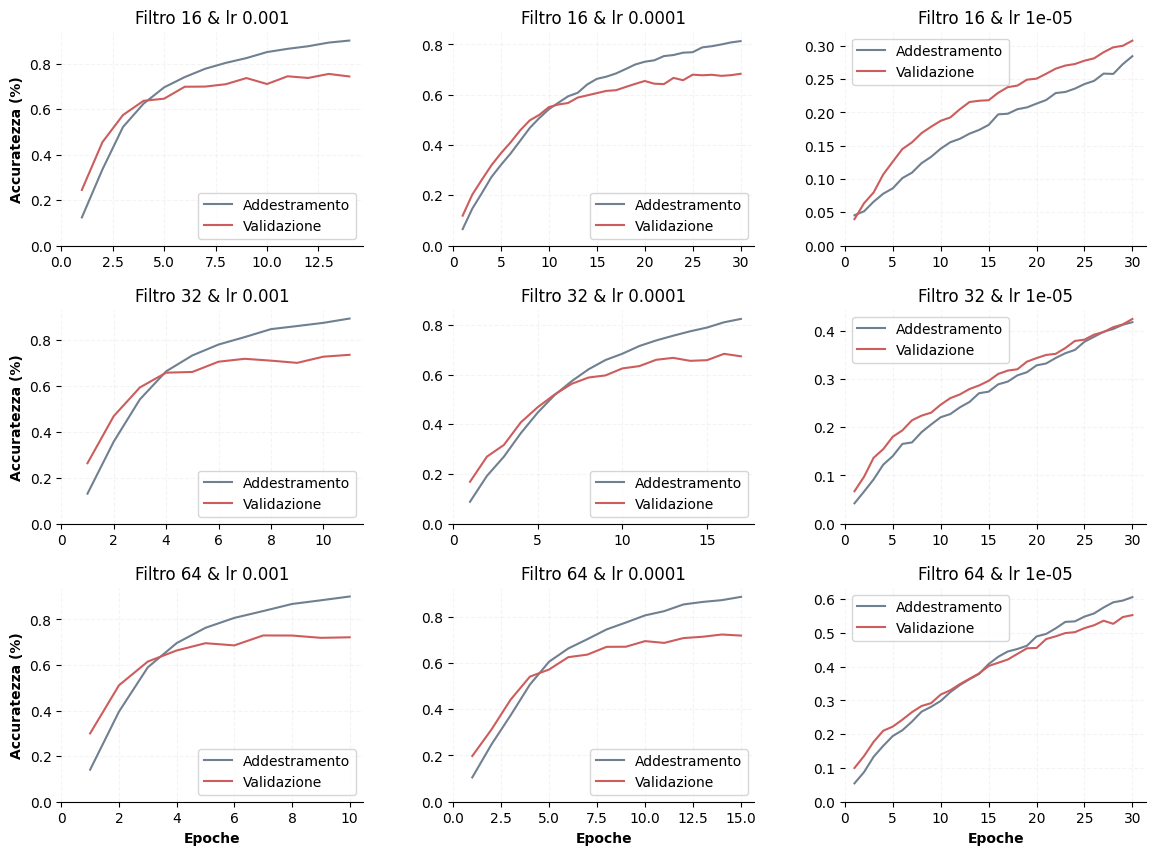

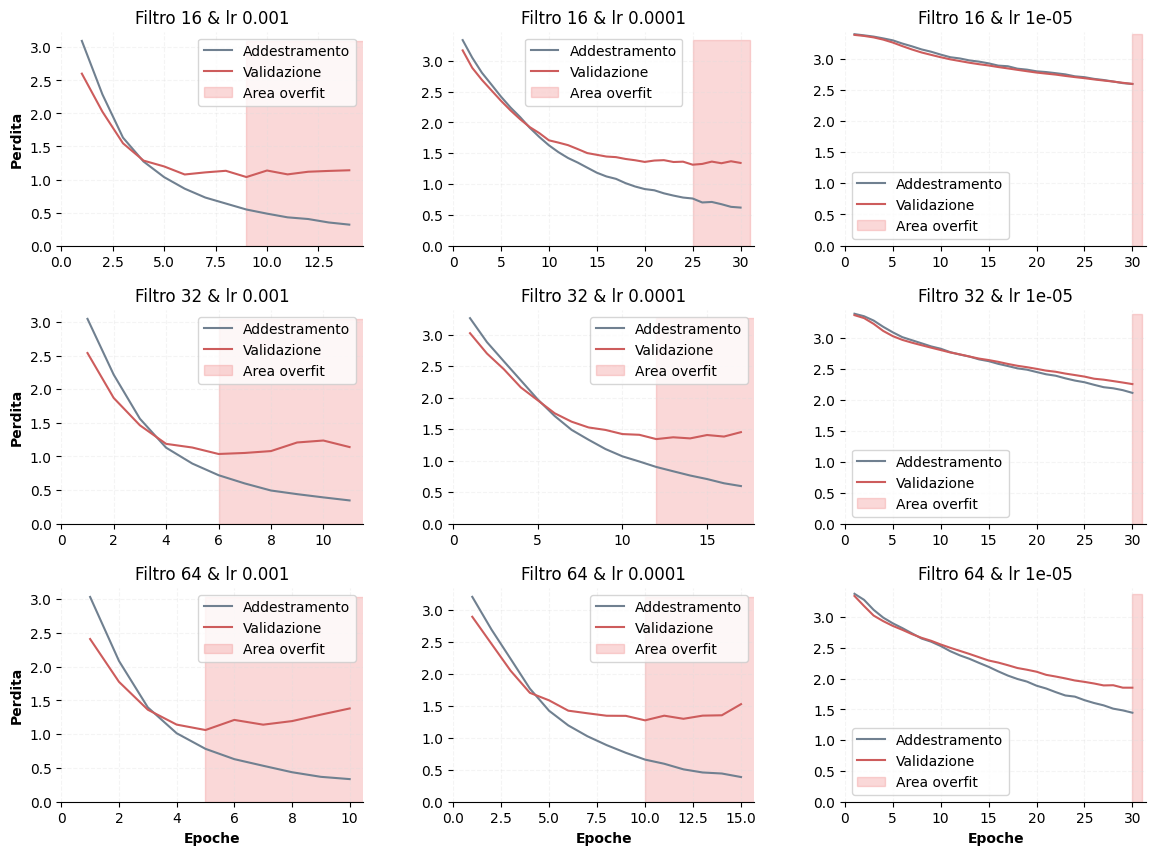

In [27]:
plot_models(path="model_tuning/noise/adam/spectrogram", show="accuracy")
plot_models(path="model_tuning/noise/adam/spectrogram", show="loss")

Dai grafici emerge che la combinazione più performante è composta da **XX filtri di partenza** e un **tasso di apprendimento di XX**, poiché ritarda maggiormente l'overfitting. Altre combinazioni, come **XX filtri di partenza** e un **tasso di apprendimento di 1e-5**, mostrano buone prestazioni ma anche un inizio di overfitting, evidenziato dallo distaccamento tra la perdita di addestramento e quella di validazione.

Procediamo quindi con l'addestramento del modello con **XX filtri di partenza** e un **tasso di apprendimento di XX**. Come di consueto, salviamo i risultati in un file `keras` e la cronologia (history) in un file `csv`. Infine, convertiamo il file in formato `onnx`.

In [ ]:
tuned_improved_basic_model = get_improved_basic_model()
tuned_improved_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=AGGIUNGERE), metrics=["accuracy"])

In [ ]:
tuned_improved_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/noise/adam/tuned_improved_basic_model.keras", save_best_only=True, monitor="val_loss")]
tuned_improved_history = tuned_improved_basic_model.fit(mixed_train_ds, epochs=100, validation_data=mixed_val_ds, callbacks=tuned_improved_basic_model_callbacks)

In [ ]:
tuned_improved_history_df = convert_history_to_csv(tuned_improved_history)
tuned_improved_history_df.to_csv("model_histories/noise/adam/tuned_improved_history.csv")

convert_model_to_onnx("bestmodels/noise/adam/tuned_improved_basic_model.keras", (124, 129, 1))

In [ ]:
create_train_val_plot(tuned_improved_history.history)

In [ ]:
tuned_improved_best_model = tf.keras.models.load_model("bestmodels/noise/adam/tuned_improved_basic_model.keras")
test_loss, test_acc = tuned_improved_best_model.evaluate(mixed_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

In [ ]:
evaluate_onnx_model("bestmodels/noise/adam/tuned_improved_basic_model.onnx", mixed_test_ds)

AGGIUNGERE COMMENTO SU COME SI E' AGGIORNATO. L'accuratezza è attualmente **XX%**.

In [ ]:
for audio, label in mixed_test_ds:
    create_distribution_plot(tuned_improved_best_model, audio, label)
    break

### Miglioramenti all'architettura del modello
Procediamo quindi con la fase corrispettiva al notebook di riferimento.

In [28]:
def residual_block(x, filters, pooling=False):
    residual = x

    x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    if pooling:
      x = tf.keras.layers.MaxPooling2D(pool_size=2, padding="same")(x)
      residual = tf.keras.layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
      residual = tf.keras.layers.Conv2D(filters, 1)(residual)

    x = tf.keras.layers.add([x, residual])
    return x

In [29]:
def bp_basic_model():
    # input e pre processamento
    inputs = tf.keras.Input(shape=(124, 129, 1))
    
    x = residual_block(inputs, 32, pooling=True)
    x = residual_block(x, 64, pooling=True)
    x = residual_block(x, 128, pooling=True)
    x = residual_block(x, 256, pooling=True)
    x = residual_block(x, 256, pooling=False)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Livelli per la classificazione
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [30]:
bp_basic_model = bp_basic_model()
bp_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [31]:
bp_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/noise/adam/spectrogram/bp_basic_model.keras", save_best_only=True, monitor="val_loss")]
bp_model_history = bp_basic_model.fit(spect_mixed_train_ds, epochs=100, validation_data=spect_mixed_val_ds, callbacks=bp_basic_model_callbacks)

Epoch 1/100
243/243 [==============================] - 6s 20ms/step - loss: 3.4229 - accuracy: 0.0647 - val_loss: 3.3903 - val_accuracy: 0.0432
Epoch 2/100
243/243 [==============================] - 5s 20ms/step - loss: 3.0831 - accuracy: 0.1250 - val_loss: 3.0395 - val_accuracy: 0.1420
Epoch 3/100
243/243 [==============================] - 5s 19ms/step - loss: 2.8690 - accuracy: 0.1796 - val_loss: 2.7849 - val_accuracy: 0.1991
Epoch 4/100
243/243 [==============================] - 5s 20ms/step - loss: 2.6451 - accuracy: 0.2394 - val_loss: 2.6321 - val_accuracy: 0.2542
Epoch 5/100
243/243 [==============================] - 5s 20ms/step - loss: 2.3799 - accuracy: 0.3253 - val_loss: 2.3088 - val_accuracy: 0.3623
Epoch 6/100
243/243 [==============================] - 5s 20ms/step - loss: 2.1431 - accuracy: 0.3985 - val_loss: 2.0565 - val_accuracy: 0.4136
Epoch 7/100
243/243 [==============================] - 5s 20ms/step - loss: 1.9179 - accuracy: 0.4631 - val_loss: 1.8390 - val_accuracy:

Salviamo nuovamente la history del modello in un file csv e convertiamo il miglior modello nel formato **.onnx**.

In [32]:
bp_model_history_df = convert_history_to_csv(bp_model_history)
bp_model_history_df.to_csv("model_histories/noise/adam/spectrogram/bp_model_history.csv")

convert_model_to_onnx("bestmodels/noise/adam/spectrogram/bp_basic_model.keras", (124, 129, 1))

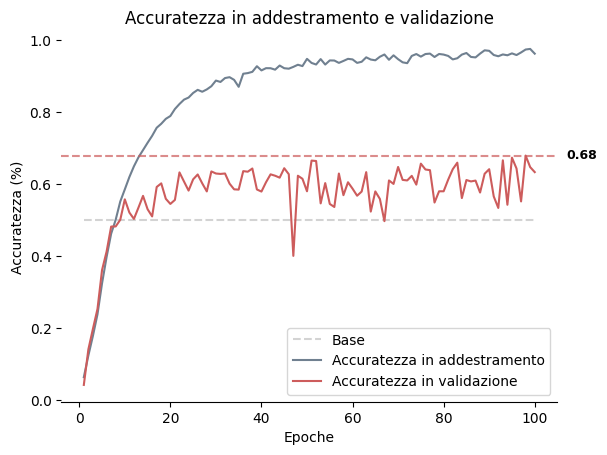

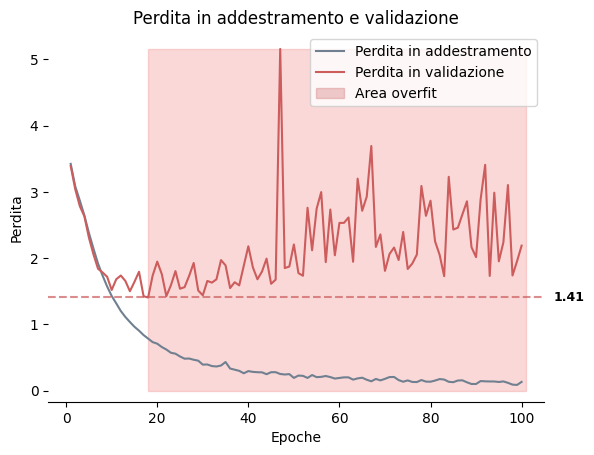

In [33]:
create_train_val_plot(bp_model_history.history)

In questo caso il modello **HA raggiunto una fase di overfitting**, inoltre le prestazioni sono diminuite di parecchio sotto qualsiasi aspetto.

In [34]:
best_bp_basic_model = tf.keras.models.load_model("bestmodels/noise/adam/spectrogram/bp_basic_model.keras")
test_loss, test_acc = best_bp_basic_model.evaluate(spect_mixed_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 1s 5ms/step - loss: 1.4223 - accuracy: 0.6048
Accuratezza: 0.605


In [35]:
evaluate_onnx_model("bestmodels/noise/adam/spectrogram/bp_basic_model.onnx", spect_mixed_test_ds)

Accuratezza: 0.605


Abbiamo ottenuto un forte peggioramento per quanto riguarda l'accuratezza, ottenendo un **60.5%**.

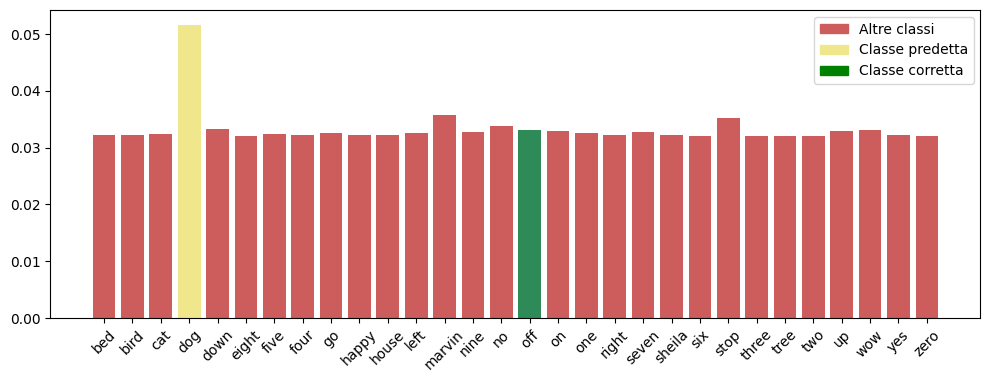

In [36]:
for audio, label in spect_mixed_test_ds:
    create_distribution_plot(best_bp_basic_model, audio, label)
    break

## Addestramento (filterbanks)
Procederemo con lo stesso approccio degli spettrogrammi, ma dando in input dei filterbanks con rumore.

In [37]:
fb_mixed_train_ds = DatasetConverter(mixed_train_ds)
fb_mixed_train_ds = fb_mixed_train_ds.convert("filterbanks")

fb_mixed_validation_ds = DatasetConverter(mixed_validation_ds)
fb_mixed_validation_ds = fb_mixed_validation_ds.convert("filterbanks")

fb_mixed_val_ds = fb_mixed_validation_ds.take(fb_mixed_validation_ds.cardinality() // 2) # ho cambiato nome del validation_ds in modo tale da non creare problemi con l'istruzione seguente
fb_mixed_test_ds = fb_mixed_validation_ds.skip(fb_mixed_validation_ds.cardinality() // 2)

In [38]:
for audio, label in fb_mixed_train_ds:
    basic_model = get_basic_model(audio.shape[1:])
    break
    
basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/noise/adam/filterbanks/basic_model_fb.keras", save_best_only=True, monitor="val_loss")]
basic_model_history = basic_model.fit(fb_mixed_train_ds, epochs=30, validation_data=fb_mixed_val_ds, callbacks=basic_model_callbacks)

Epoch 1/30
243/243 [==============================] - 2s 5ms/step - loss: 3.5082 - accuracy: 0.0438 - val_loss: 3.2233 - val_accuracy: 0.0818
Epoch 2/30
243/243 [==============================] - 1s 4ms/step - loss: 2.8704 - accuracy: 0.1572 - val_loss: 2.5327 - val_accuracy: 0.2627
Epoch 3/30
243/243 [==============================] - 1s 4ms/step - loss: 2.1196 - accuracy: 0.3716 - val_loss: 1.7601 - val_accuracy: 0.4977
Epoch 4/30
243/243 [==============================] - 1s 4ms/step - loss: 1.4408 - accuracy: 0.5649 - val_loss: 1.5062 - val_accuracy: 0.5590
Epoch 5/30
243/243 [==============================] - 1s 4ms/step - loss: 1.0720 - accuracy: 0.6731 - val_loss: 1.3738 - val_accuracy: 0.6061
Epoch 6/30
243/243 [==============================] - 1s 4ms/step - loss: 0.8409 - accuracy: 0.7366 - val_loss: 1.4531 - val_accuracy: 0.5980
Epoch 7/30
243/243 [==============================] - 1s 4ms/step - loss: 0.6903 - accuracy: 0.7794 - val_loss: 1.3372 - val_accuracy: 0.6555
Epoch 

Salviamo i dati della history del modello in un file csv

In [39]:
basic_model_history_df = convert_history_to_csv(basic_model_history)
basic_model_history_df.to_csv("model_histories/noise/adam/filterbanks/basic_model_history_fb.csv")

convert_model_to_onnx("bestmodels/noise/adam/filterbanks/basic_model_fb.keras", (98, 40, 1))

Visualizziamo l'andamento dell'accuratezza e della perdita durante l'addestramento.

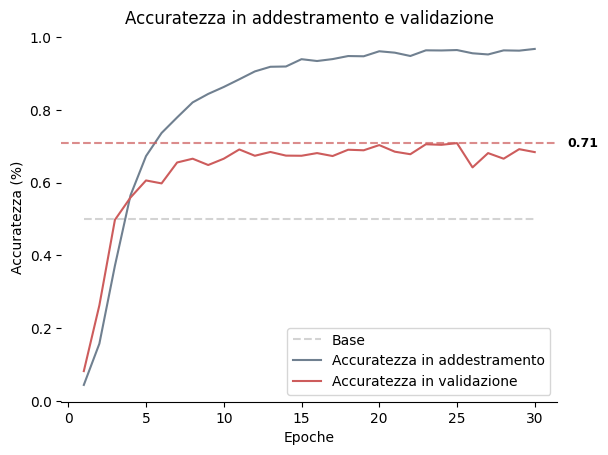

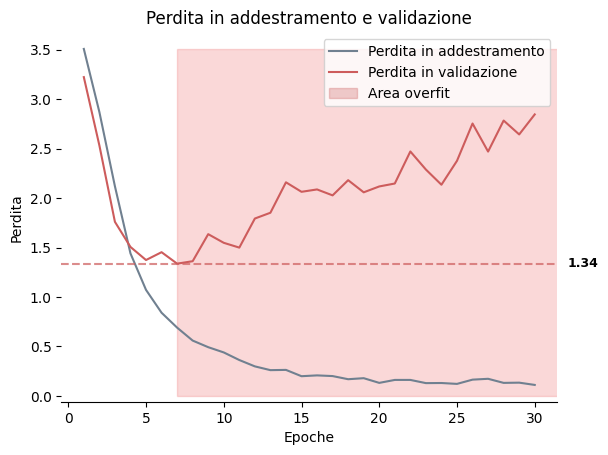

In [40]:
create_train_val_plot(basic_model_history.history)

Verifichiamo l'accuratezza della migliore versione del nostro modello di base ricaricando il file **basic_model.keras**.

In [41]:
best_basic_model = tf.keras.models.load_model("bestmodels/noise/adam/filterbanks/basic_model_fb.keras")
test_loss, test_acc = best_basic_model.evaluate(fb_mixed_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 0s 2ms/step - loss: 1.3054 - accuracy: 0.6618
Accuratezza: 0.662


In [42]:
evaluate_onnx_model("bestmodels/noise/adam/filterbanks/basic_model_fb.onnx", fb_mixed_test_ds)

Accuratezza: 0.662


Abbiamo ottenuto un'**accuratezza** del **70.6%**, possiamo già notare un piccolo miglioramento rispetto agli spettrogrammi. Visualizziamo la distribuzione di accuratezza delle classi su un'immagine casuale.

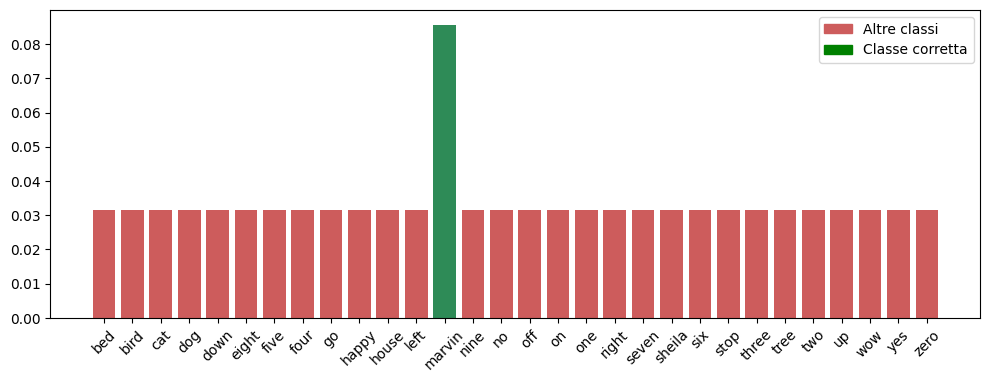

In [43]:
for audio, label in fb_mixed_test_ds: # prendiamo un audio a caso del test e creiamo la distribuzione
    create_distribution_plot(best_basic_model, audio, label)
    break

### Risoluzione dell'overfitting
Ovviamente il modello è andato immediatamente in **overfitting**, perciò ripetiamo i metodi applicati precedentemente.

In [44]:
for audio, label in fb_mixed_train_ds:
    improved_basic_model = get_improved_basic_model(audio.shape[1:])
    break

improved_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

improved_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/noise/adam/filterbanks/improved_basic_model_fb.keras", save_best_only=True, monitor="val_loss")]
improved_history = improved_basic_model.fit(fb_mixed_train_ds, epochs=100, validation_data=fb_mixed_val_ds, callbacks=improved_basic_model_callbacks)

Epoch 1/100
243/243 [==============================] - 1s 5ms/step - loss: 3.4982 - accuracy: 0.0349 - val_loss: 3.3953 - val_accuracy: 0.0316
Epoch 2/100
243/243 [==============================] - 1s 4ms/step - loss: 3.2801 - accuracy: 0.0684 - val_loss: 3.0466 - val_accuracy: 0.1208
Epoch 3/100
243/243 [==============================] - 1s 4ms/step - loss: 2.8588 - accuracy: 0.1608 - val_loss: 2.4272 - val_accuracy: 0.2894
Epoch 4/100
243/243 [==============================] - 1s 4ms/step - loss: 2.2406 - accuracy: 0.3410 - val_loss: 1.8288 - val_accuracy: 0.4522
Epoch 5/100
243/243 [==============================] - 1s 4ms/step - loss: 1.6138 - accuracy: 0.5165 - val_loss: 1.3348 - val_accuracy: 0.5995
Epoch 6/100
243/243 [==============================] - 1s 4ms/step - loss: 1.2325 - accuracy: 0.6274 - val_loss: 1.1522 - val_accuracy: 0.6632
Epoch 7/100
243/243 [==============================] - 1s 4ms/step - loss: 1.0363 - accuracy: 0.6844 - val_loss: 1.1645 - val_accuracy: 0.6651

Salviamo come prima la history del modello in un file csv, e convertiamo il miglior modello nel formato **.onnx**.

In [45]:
improved_history_df = convert_history_to_csv(improved_history)
improved_history_df.to_csv("model_histories/noise/adam/filterbanks/improved_history_fb.csv")

convert_model_to_onnx("bestmodels/noise/adam/filterbanks/improved_basic_model_fb.keras", (98, 40, 1))

Visualizziamo la curva dell'accuratezza e della perdita durante l'addestramento.

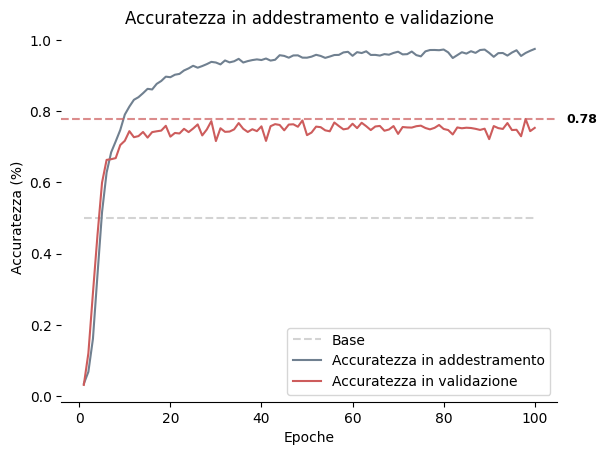

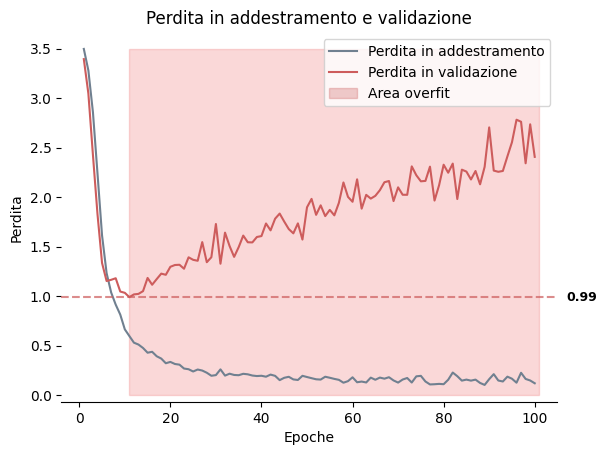

In [46]:
create_train_val_plot(improved_history.history)

Le prestazioni sono migliorate rispetto all'applicazione precedente. Verifichiamo l'accuratezza nel dataset di test.

In [47]:
improved_best_model = tf.keras.models.load_model("bestmodels/noise/adam/filterbanks/improved_basic_model_fb.keras")
test_loss, test_acc = improved_best_model.evaluate(fb_mixed_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 0s 2ms/step - loss: 1.0412 - accuracy: 0.7269
Accuratezza: 0.727


In [48]:
evaluate_onnx_model("bestmodels/noise/adam/filterbanks/improved_basic_model_fb.onnx", fb_mixed_test_ds)

Accuratezza: 0.727


Abbiamo ottenuto un notevole miglioramento dell'accuratezza, attualmente siamo a quota **75.4%**! Visualizziamo anche la solita distribuzione.

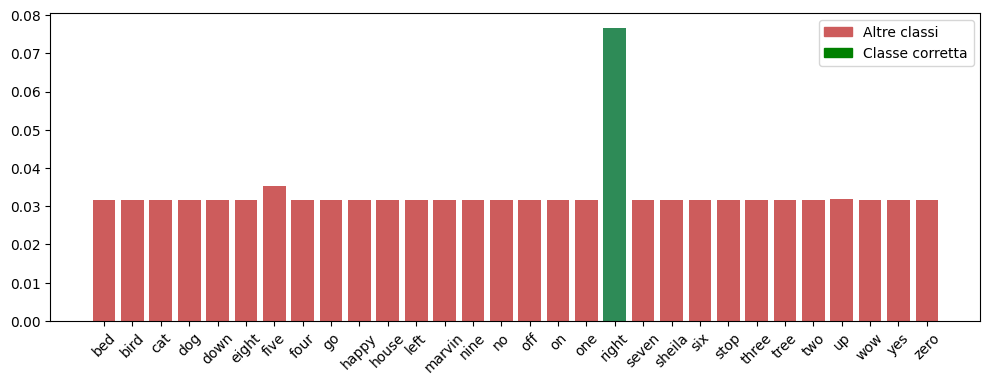

In [49]:
for audio, label in fb_mixed_test_ds:
    create_distribution_plot(improved_best_model, audio, label)
    break

### Fine tuning
Anche per questa sezione, andiamo a ripetere gli stessi passaggi degli spettrogrammi.

In [50]:
def get_improved_basic_model_tuning(start_filters):
    # Dichiariamo lo shape dell'input, ridimensioniamo le immagini, e normalizziamo
    inputs = tf.keras.Input(shape=(98, 40, 1))
    x = tf.keras.layers.Normalization()(inputs)

    if not isinstance(start_filters, int):
        raise Exception("start_filters must be type integer")

    filters = [start_filters * (2 ** i) for i in range(4)]
    
    # Blocco di apprendimento delle caratteristiche
    x = tf.keras.layers.Conv2D(filters=filters[0], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=filters[1], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=filters[2], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=filters[3], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=filters[3], kernel_size=3, activation="relu", padding="same")(x)

    # Blocco di classificazione
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

def tuner(filters, learning_rates, max_epochs, train_dataset, validation_dataset):
    start_time = time.time()

    counter = 1
    
    if not isinstance(filters, list):
        raise Exception("parameter filters must be type list")

    if not isinstance(learning_rates, list):
        raise Exception("parameter learning_rates must be type list")

    callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]

    best_learning_rate = 0 
    best_filters = 0
    best_val_accuracy = 0

    best_model = 0
    
    for f in filters:
        for lr in learning_rates:
            print(f"\nAddestrando con filtri {[f * (2 ** i) for i in range(4)]} e tasso di apprendimento {lr}")
            
            model = get_improved_basic_model_tuning(start_filters=f)
            model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=["accuracy"])
            model_history = model.fit(train_dataset, epochs=max_epochs, validation_data=validation_dataset, callbacks=callbacks)

            model_history_df = convert_history_to_csv(model_history)

            model_history_df[["filters"]] = f
            model_history_df[["learning_rate"]] = lr
            
            path = "model_tuning/noise/adam/filterbanks/model_" + str(counter) + ".csv"
            model_history_df.to_csv(path)
            
            if best_val_accuracy < model_history_df.iloc[-1]["val_accuracy"]:
                best_val_accuracy = model_history_df.iloc[-1]["val_accuracy"]
                best_filters = f
                best_learning_rate = lr
                epoch = len(model_history_df)

            del model

            counter += 1

    total_time = time.time() - start_time
    minutes, seconds = divmod(total_time, 60)
    print(f"\nTempo totale trascorso: {int(minutes)} minuti e {int(seconds)} secondi")
    # print(f"Il miglior modello ha un filtro di partenza pari a {best_filters}, un learning rate pari a {best_learning_rate} con un'accuracy pari a {best_val_accuracy:.3f}")

    return best_filters, best_learning_rate

best_filter, best_learning_rate = tuner([16, 32, 64], [1e-3, 1e-4, 1e-5], 30, fb_mixed_train_ds, fb_mixed_val_ds)


Addestrando con filtri [16, 32, 64, 128] e tasso di apprendimento 0.001
Epoch 1/30
243/243 [==============================] - 1s 4ms/step - loss: 3.4807 - accuracy: 0.0336 - val_loss: 3.3935 - val_accuracy: 0.0278
Epoch 2/30
243/243 [==============================] - 1s 4ms/step - loss: 3.3949 - accuracy: 0.0405 - val_loss: 3.3921 - val_accuracy: 0.0293
Epoch 3/30
243/243 [==============================] - 1s 3ms/step - loss: 3.1580 - accuracy: 0.0979 - val_loss: 2.9262 - val_accuracy: 0.1416
Epoch 4/30
243/243 [==============================] - 1s 3ms/step - loss: 2.6666 - accuracy: 0.2063 - val_loss: 2.3932 - val_accuracy: 0.2867
Epoch 5/30
243/243 [==============================] - 1s 3ms/step - loss: 2.0744 - accuracy: 0.3800 - val_loss: 1.6714 - val_accuracy: 0.4973
Epoch 6/30
243/243 [==============================] - 1s 3ms/step - loss: 1.6317 - accuracy: 0.5035 - val_loss: 1.3655 - val_accuracy: 0.5903
Epoch 7/30
243/243 [==============================] - 1s 3ms/step - loss: 1

Il tempo necessario per la ricerca dei migliori iperparametri è stata di **4 minuti**.

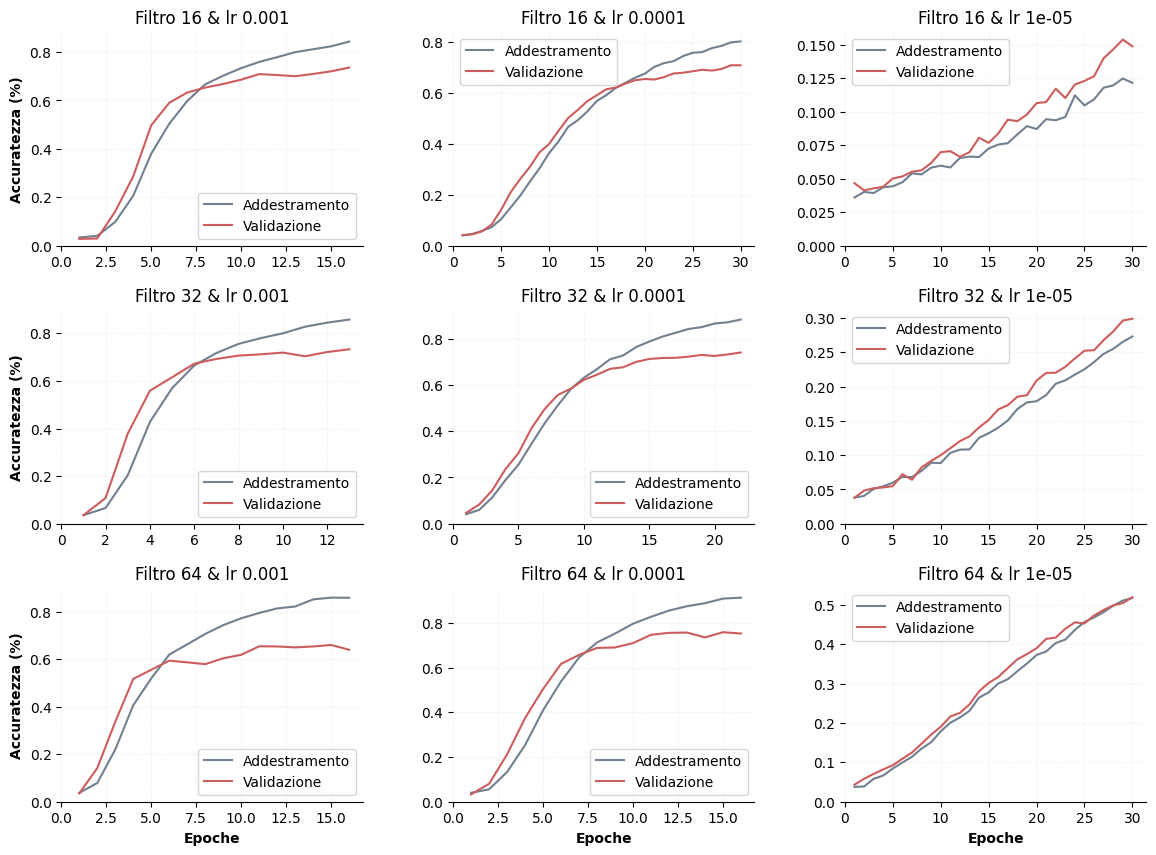

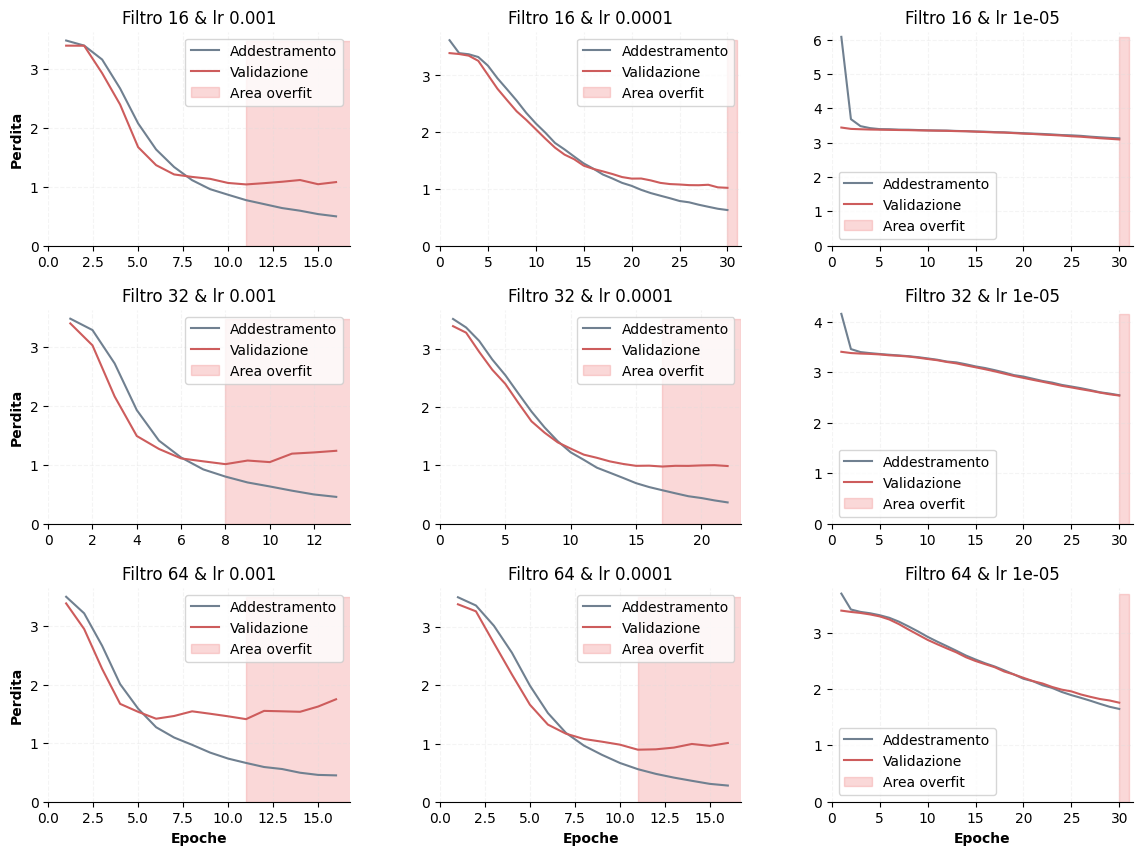

In [51]:
plot_models(path="model_tuning/noise/adam/filterbanks", show="accuracy")
plot_models(path="model_tuning/noise/adam/filterbanks", show="loss")

Dai grafici emerge che la combinazione più performante è composta da **XX filtri di partenza** e un **tasso di apprendimento di XX**, poiché ritarda maggiormente l'overfitting. Altre combinazioni, come **XX filtri di partenza** e un **tasso di apprendimento di 1e-5**, mostrano buone prestazioni ma anche un inizio di overfitting, evidenziato dallo distaccamento tra la perdita di addestramento e quella di validazione.

Procediamo quindi con l'addestramento del modello con **XX filtri di partenza** e un **tasso di apprendimento di XX**. Come di consueto, salviamo i risultati in un file `keras` e la cronologia (history) in un file `csv`. Infine, convertiamo il file in formato `onnx`.

In [ ]:
for audio, label in fb_mixed_train_ds:
    tuned_improved_basic_model = get_improved_basic_model(audio.shape[1:])
    
tuned_improved_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=AGGIUNGERE), metrics=["accuracy"])

tuned_improved_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/noise/adam/filterbanks/tuned_improved_basic_model_fb.keras", save_best_only=True, monitor="val_loss")]
tuned_improved_history = tuned_improved_basic_model.fit(fb_mixed_train_ds, epochs=100, validation_data=fb_mixed_val_ds, callbacks=tuned_improved_basic_model_callbacks)

In [ ]:
tuned_improved_history_df = convert_history_to_csv(tuned_improved_history)
tuned_improved_history_df.to_csv("model_histories/noise/adam/filterbanks/tuned_improved_history_fb.csv")

convert_model_to_onnx("bestmodels/noise/adam/filterbanks/tuned_improved_basic_model_fb.keras", (124, 129, 1))

In [ ]:
create_train_val_plot(tuned_improved_history.history)

In [ ]:
tuned_improved_best_model = tf.keras.models.load_model("bestmodels/noise/adam/filterbanks/tuned_improved_basic_model_fb.keras")
test_loss, test_acc = tuned_improved_best_model.evaluate(fb_mixed_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

In [ ]:
evaluate_onnx_model("bestmodels/noise/adam/filterbanks/tuned_improved_basic_model_fb.onnx", fb_mixed_test_ds)

AGGIUNGERE COMMENTO SU COME SI E' AGGIORNATO. L'accuratezza è attualmente **XX%**.

In [ ]:
for audio, label in fb_mixed_test_ds:
    create_distribution_plot(tuned_improved_best_model, audio, label)
    break

### Miglioramenti all'architettura del modello
Procediamo quindi con la fase corrispettiva al notebook di riferimento.

In [52]:
def bp_basic_model():
    # input e pre processamento
    inputs = tf.keras.Input(shape=(98, 40, 1))
    
    x = residual_block(inputs, 32, pooling=True)
    x = residual_block(x, 64, pooling=True)
    x = residual_block(x, 128, pooling=True)
    x = residual_block(x, 256, pooling=True)
    x = residual_block(x, 256, pooling=False)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Livelli per la classificazione
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [53]:
bp_basic_model = bp_basic_model()
bp_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

bp_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/noise/adam/filterbanks/bp_basic_model_fb.keras", save_best_only=True, monitor="val_loss")]
bp_model_history = bp_basic_model.fit(fb_mixed_train_ds, epochs=100, validation_data=fb_mixed_val_ds, callbacks=bp_basic_model_callbacks)

Epoch 1/100
243/243 [==============================] - 3s 7ms/step - loss: 5.1627 - accuracy: 0.0415 - val_loss: 3.6774 - val_accuracy: 0.0355
Epoch 2/100
243/243 [==============================] - 2s 7ms/step - loss: 3.4074 - accuracy: 0.0769 - val_loss: 3.3301 - val_accuracy: 0.0841
Epoch 3/100
243/243 [==============================] - 2s 6ms/step - loss: 3.0465 - accuracy: 0.1396 - val_loss: 3.4346 - val_accuracy: 0.1250
Epoch 4/100
243/243 [==============================] - 2s 7ms/step - loss: 2.7249 - accuracy: 0.2133 - val_loss: 3.0005 - val_accuracy: 0.1794
Epoch 5/100
243/243 [==============================] - 2s 7ms/step - loss: 2.4236 - accuracy: 0.2911 - val_loss: 2.3931 - val_accuracy: 0.3090
Epoch 6/100
243/243 [==============================] - 2s 7ms/step - loss: 2.1290 - accuracy: 0.3742 - val_loss: 2.5015 - val_accuracy: 0.3144
Epoch 7/100
243/243 [==============================] - 2s 7ms/step - loss: 1.8748 - accuracy: 0.4495 - val_loss: 2.0495 - val_accuracy: 0.3881

Salviamo nuovamente la history del modello in un file csv e convertiamo il miglior modello nel formato **.onnx**.

In [54]:
bp_model_history_df = convert_history_to_csv(bp_model_history)
bp_model_history_df.to_csv("model_histories/noise/adam/filterbanks/bp_model_history_fb.csv")

convert_model_to_onnx("bestmodels/noise/adam/filterbanks/bp_basic_model_fb.keras", (98, 40, 1))

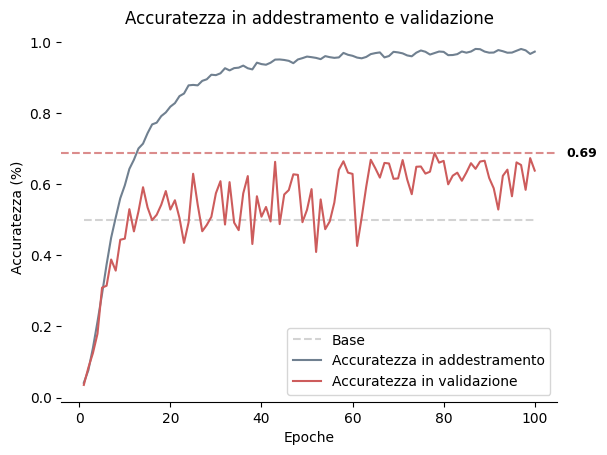

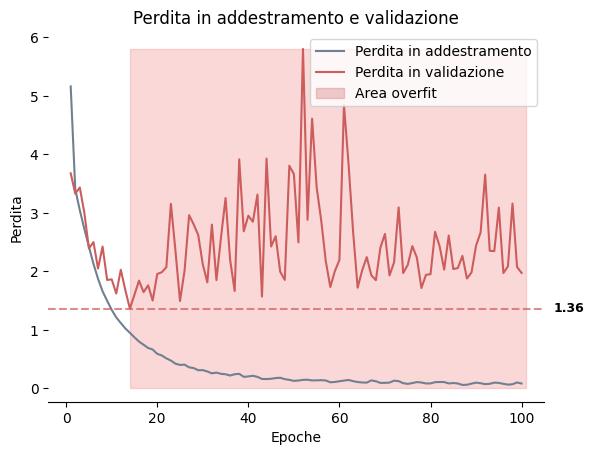

In [55]:
create_train_val_plot(bp_model_history.history)

In questo caso il modello **HA raggiunto una fase di overfitting**, inoltre le prestazioni sono diminuite di parecchio sotto qualsiasi aspetto.

In [56]:
best_bp_basic_model = tf.keras.models.load_model("bestmodels/noise/adam/filterbanks/bp_basic_model_fb.keras")
test_loss, test_acc = best_bp_basic_model.evaluate(fb_mixed_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 0s 2ms/step - loss: 1.3533 - accuracy: 0.6017
Accuratezza: 0.602


In [57]:
evaluate_onnx_model("bestmodels/noise/adam/filterbanks/bp_basic_model_fb.onnx", fb_mixed_test_ds)

Accuratezza: 0.602


Abbiamo ottenuto un forte peggioramento per quanto riguarda l'accuratezza, ottenendo un **62%**.

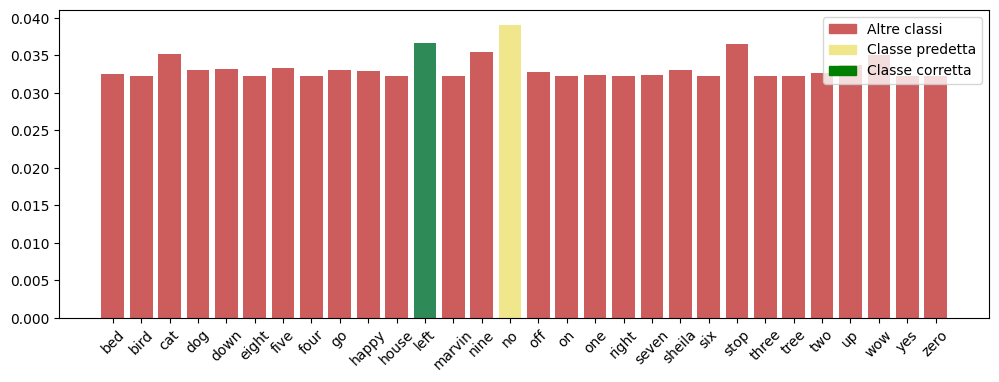

In [58]:
for audio, label in fb_mixed_test_ds:
    create_distribution_plot(best_bp_basic_model, audio, label)
    break

## Addestramento (MFCC)
Ripetiamo nuovamente tutti i passaggi ma per gli mfcc.

In [59]:
mfcc_mixed_train_ds = DatasetConverter(mixed_train_ds)
mfcc_mixed_train_ds = mfcc_mixed_train_ds.convert("mfcc")

mfcc_mixed_validation_ds = DatasetConverter(mixed_validation_ds)
mfcc_mixed_validation_ds = mfcc_mixed_validation_ds.convert("mfcc")

mfcc_mixed_val_ds = mfcc_mixed_validation_ds.take(mfcc_mixed_validation_ds.cardinality() // 2) # ho cambiato nome del validation_ds in modo tale da non creare problemi con l'istruzione seguente
mfcc_mixed_test_ds = mfcc_mixed_validation_ds.skip(mfcc_mixed_validation_ds.cardinality() // 2)

In [60]:
def get_basic_model(input_shape):
    # Dichiariamo lo shape dell'input, ridimensioniamo le immagini, e normalizziamo
    inputs = tf.keras.Input(shape=input_shape, name="inputs")
    x = tf.keras.layers.Normalization(name="normalizzazione")(inputs)

    # Blocco di apprendimento delle caratteristiche
    conv2D_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same", name="conv2D_1")(x)
    MaxPooling2D_1 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_1")(conv2D_1)
    conv2D_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same", name="conv2D_2")(MaxPooling2D_1)
    MaxPooling2D_2 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_2")(conv2D_2)
    conv2D_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same", name="conv2D_3")(MaxPooling2D_2)
    MaxPooling2D_3 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_3")(conv2D_3)
    conv2D_4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same", name="conv2D_4")(MaxPooling2D_3)
    MaxPooling2D_4 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_4", padding="same")(conv2D_4)
    conv2D_5 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same", name="conv2D_5")(MaxPooling2D_4)

    # Blocco di classificazione
    Flatten = tf.keras.layers.Flatten(name="Flatten")(conv2D_5)
    outputs = tf.keras.layers.Dense(30, activation="softmax", name="dense_output")(Flatten)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [61]:
for audio, label in mfcc_mixed_train_ds:
    basic_model = get_basic_model(audio.shape[1:])
    break
    
basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/noise/adam/mfcc/basic_model_mfcc.keras", save_best_only=True, monitor="val_loss")]
basic_model_history = basic_model.fit(mfcc_mixed_train_ds, epochs=30, validation_data=mfcc_mixed_val_ds, callbacks=basic_model_callbacks)

Epoch 1/30
243/243 [==============================] - 2s 5ms/step - loss: 3.3545 - accuracy: 0.0682 - val_loss: 2.9868 - val_accuracy: 0.1420
Epoch 2/30
243/243 [==============================] - 1s 4ms/step - loss: 2.6207 - accuracy: 0.2352 - val_loss: 2.2073 - val_accuracy: 0.3650
Epoch 3/30
243/243 [==============================] - 1s 4ms/step - loss: 1.9435 - accuracy: 0.4249 - val_loss: 1.7801 - val_accuracy: 0.4834
Epoch 4/30
243/243 [==============================] - 1s 4ms/step - loss: 1.4955 - accuracy: 0.5495 - val_loss: 1.6907 - val_accuracy: 0.5089
Epoch 5/30
243/243 [==============================] - 1s 4ms/step - loss: 1.2382 - accuracy: 0.6214 - val_loss: 1.7241 - val_accuracy: 0.5343
Epoch 6/30
243/243 [==============================] - 1s 4ms/step - loss: 1.0508 - accuracy: 0.6780 - val_loss: 1.8849 - val_accuracy: 0.5347
Epoch 7/30
243/243 [==============================] - 1s 4ms/step - loss: 0.9052 - accuracy: 0.7157 - val_loss: 1.9185 - val_accuracy: 0.5502
Epoch 

Salviamo i dati della history del modello in un file csv

In [62]:
basic_model_history_df = convert_history_to_csv(basic_model_history)
basic_model_history_df.to_csv("model_histories/noise/adam/mfcc/basic_model_history_mfcc.csv")

convert_model_to_onnx("bestmodels/noise/adam/mfcc/basic_model_mfcc.keras", (98, 12, 1))

Visualizziamo l'andamento dell'accuratezza e della perdita durante l'addestramento.

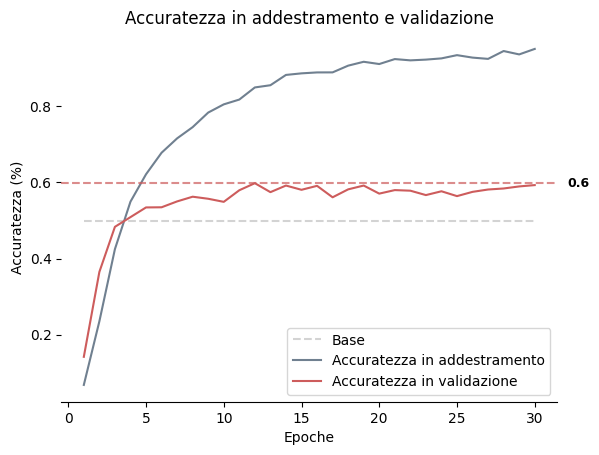

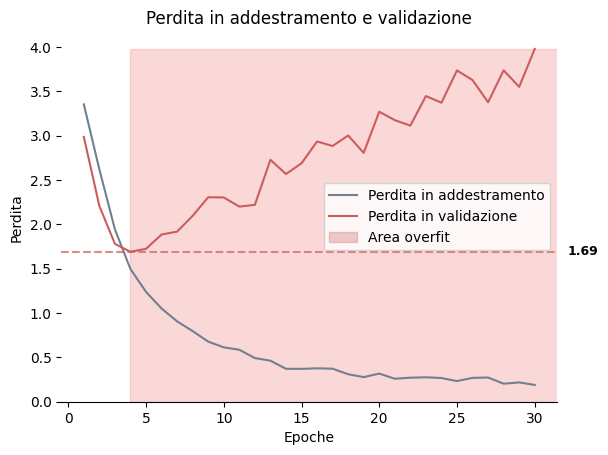

In [63]:
create_train_val_plot(basic_model_history.history)

Verifichiamo l'accuratezza della migliore versione del nostro modello di base ricaricando il file **basic_model.keras**.

In [64]:
best_basic_model = tf.keras.models.load_model("bestmodels/noise/adam/mfcc/basic_model_mfcc.keras")
test_loss, test_acc = best_basic_model.evaluate(mfcc_mixed_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 0s 2ms/step - loss: 1.7100 - accuracy: 0.4955
Accuratezza: 0.496


In [65]:
evaluate_onnx_model("bestmodels/noise/adam/mfcc/basic_model_mfcc.onnx", mfcc_mixed_test_ds)

Accuratezza: 0.496


Abbiamo ottenuto un'**accuratezza** del **60.8%**. Il modello è di poco al disto del lancio della moneta, perciò non è per niente buono.

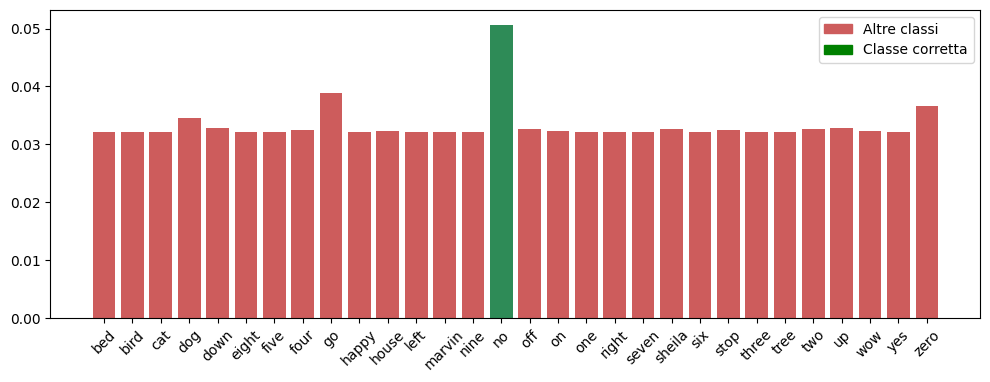

In [66]:
for audio, label in mfcc_mixed_test_ds: # prendiamo un audio a caso del test e creiamo la distribuzione
    create_distribution_plot(best_basic_model, audio, label)
    break

Possiamo notare molta indecisione nella distribuzione dei dati.

### Risoluzione dell'overfitting
Ovviamente il modello è andato immediatamente in **overfitting**, perciò ripetiamo i metodi applicati precedentemente.

In [67]:
def get_improved_basic_model(input_shape):
    # Dichiariamo lo shape dell'input, ridimensioniamo le immagini, e normalizziamo
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Normalization()(inputs)

    # Blocco di apprendimento delle caratteristiche
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

    # Blocco di classificazione
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [68]:
for audio, label in mfcc_mixed_train_ds:
    improved_basic_model = get_improved_basic_model(audio.shape[1:])
    break

improved_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

improved_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/noise/adam/mfcc/improved_basic_model_mfcc.keras", save_best_only=True, monitor="val_loss")]
improved_history = improved_basic_model.fit(mfcc_mixed_train_ds, epochs=100, validation_data=mfcc_mixed_val_ds, callbacks=improved_basic_model_callbacks)

Epoch 1/100
243/243 [==============================] - 1s 4ms/step - loss: 3.4415 - accuracy: 0.0474 - val_loss: 3.2395 - val_accuracy: 0.0714
Epoch 2/100
243/243 [==============================] - 1s 4ms/step - loss: 3.0922 - accuracy: 0.1070 - val_loss: 2.9041 - val_accuracy: 0.1489
Epoch 3/100
243/243 [==============================] - 1s 4ms/step - loss: 2.6915 - accuracy: 0.2090 - val_loss: 2.2792 - val_accuracy: 0.3449
Epoch 4/100
243/243 [==============================] - 1s 4ms/step - loss: 2.2285 - accuracy: 0.3448 - val_loss: 1.9652 - val_accuracy: 0.4348
Epoch 5/100
243/243 [==============================] - 1s 4ms/step - loss: 1.8795 - accuracy: 0.4427 - val_loss: 1.9447 - val_accuracy: 0.4410
Epoch 6/100
243/243 [==============================] - 1s 4ms/step - loss: 1.5915 - accuracy: 0.5171 - val_loss: 1.5887 - val_accuracy: 0.5517
Epoch 7/100
243/243 [==============================] - 1s 4ms/step - loss: 1.4235 - accuracy: 0.5697 - val_loss: 1.5074 - val_accuracy: 0.5783

Salviamo come prima la history del modello in un file csv, e convertiamo il miglior modello nel formato **.onnx**.

In [69]:
improved_history_df = convert_history_to_csv(improved_history)
improved_history_df.to_csv("model_histories/noise/adam/mfcc/improved_history_mfcc.csv")

convert_model_to_onnx("bestmodels/noise/adam/mfcc/improved_basic_model_mfcc.keras", (98, 12, 1))

Visualizziamo la curva dell'accuratezza e della perdita durante l'addestramento.

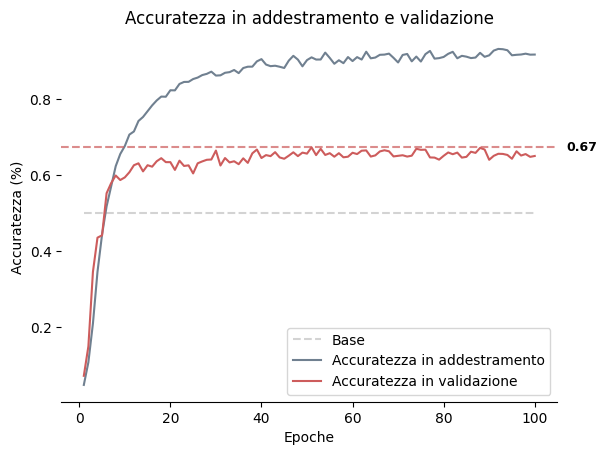

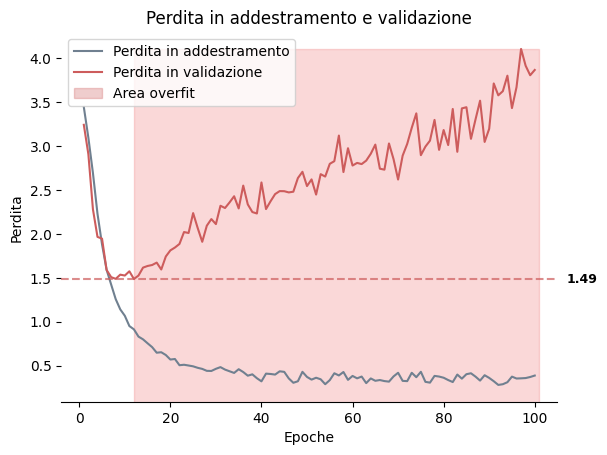

In [70]:
create_train_val_plot(improved_history.history)

Le prestazioni sono migliorate rispetto all'applicazione precedente. Verifichiamo l'accuratezza nel dataset di test.

In [71]:
improved_best_model = tf.keras.models.load_model("bestmodels/noise/adam/mfcc/improved_basic_model_mfcc.keras")
test_loss, test_acc = improved_best_model.evaluate(mfcc_mixed_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 0s 2ms/step - loss: 1.4783 - accuracy: 0.6226
Accuratezza: 0.623


In [72]:
evaluate_onnx_model("bestmodels/noise/adam/mfcc/improved_basic_model_mfcc.onnx", mfcc_mixed_test_ds)

Accuratezza: 0.623


Abbiamo ottenuto un notevole miglioramento dell'accuratezza, attualmente siamo a quota **63.8%**! Visualizziamo anche la solita distribuzione.

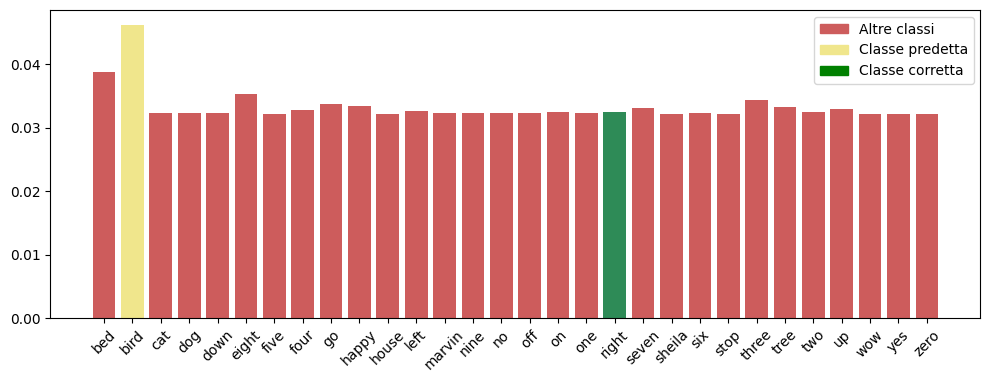

In [73]:
for audio, label in mfcc_mixed_test_ds:
    create_distribution_plot(improved_best_model, audio, label)
    break

### Fine tuning
Anche per questa sezione, andiamo a ripetere gli stessi passaggi degli spettrogrammi.

In [74]:
def get_improved_basic_model_tuning(start_filters):
    # Dichiariamo lo shape dell'input, ridimensioniamo le immagini, e normalizziamo
    inputs = tf.keras.Input(shape=(98, 12, 1))
    x = tf.keras.layers.Normalization()(inputs)

    if not isinstance(start_filters, int):
        raise Exception("start_filters must be type integer")

    filters = [start_filters * (2 ** i) for i in range(4)]
    
    # Blocco di apprendimento delle caratteristiche
    x = tf.keras.layers.Conv2D(filters=filters[0], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=filters[1], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=filters[2], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=filters[3], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = tf.keras.layers.Conv2D(filters=filters[3], kernel_size=3, activation="relu", padding="same")(x)

    # Blocco di classificazione
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

def tuner(filters, learning_rates, max_epochs, train_dataset, validation_dataset):
    start_time = time.time()

    counter = 1
    
    if not isinstance(filters, list):
        raise Exception("parameter filters must be type list")

    if not isinstance(learning_rates, list):
        raise Exception("parameter learning_rates must be type list")

    callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]

    best_learning_rate = 0 
    best_filters = 0
    best_val_accuracy = 0

    best_model = 0
    
    for f in filters:
        for lr in learning_rates:
            print(f"\nAddestrando con filtri {[f * (2 ** i) for i in range(4)]} e tasso di apprendimento {lr}")
            
            model = get_improved_basic_model_tuning(start_filters=f)
            model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=["accuracy"])
            model_history = model.fit(train_dataset, epochs=max_epochs, validation_data=validation_dataset, callbacks=callbacks)

            model_history_df = convert_history_to_csv(model_history)

            model_history_df[["filters"]] = f
            model_history_df[["learning_rate"]] = lr
            
            path = "model_tuning/noise/adam/mfcc/model_" + str(counter) + ".csv"
            model_history_df.to_csv(path)
            
            if best_val_accuracy < model_history_df.iloc[-1]["val_accuracy"]:
                best_val_accuracy = model_history_df.iloc[-1]["val_accuracy"]
                best_filters = f
                best_learning_rate = lr
                epoch = len(model_history_df)

            del model

            counter += 1

    total_time = time.time() - start_time
    minutes, seconds = divmod(total_time, 60)
    print(f"\nTempo totale trascorso: {int(minutes)} minuti e {int(seconds)} secondi")
    # print(f"Il miglior modello ha un filtro di partenza pari a {best_filters}, un learning rate pari a {best_learning_rate} con un'accuracy pari a {best_val_accuracy:.3f}")

    return best_filters, best_learning_rate

best_filter, best_learning_rate = tuner([16, 32, 64], [1e-3, 1e-4, 1e-5], 30, mfcc_mixed_train_ds, mfcc_mixed_val_ds)


Addestrando con filtri [16, 32, 64, 128] e tasso di apprendimento 0.001
Epoch 1/30
243/243 [==============================] - 1s 4ms/step - loss: 3.5179 - accuracy: 0.0374 - val_loss: 3.3854 - val_accuracy: 0.0428
Epoch 2/30
243/243 [==============================] - 1s 3ms/step - loss: 3.3587 - accuracy: 0.0521 - val_loss: 3.2183 - val_accuracy: 0.0802
Epoch 3/30
243/243 [==============================] - 1s 3ms/step - loss: 3.1579 - accuracy: 0.0861 - val_loss: 2.9553 - val_accuracy: 0.1516
Epoch 4/30
243/243 [==============================] - 1s 3ms/step - loss: 2.8930 - accuracy: 0.1582 - val_loss: 2.7105 - val_accuracy: 0.2041
Epoch 5/30
243/243 [==============================] - 1s 4ms/step - loss: 2.6361 - accuracy: 0.2197 - val_loss: 2.5098 - val_accuracy: 0.2716
Epoch 6/30
243/243 [==============================] - 1s 4ms/step - loss: 2.3782 - accuracy: 0.2919 - val_loss: 2.2112 - val_accuracy: 0.3526
Epoch 7/30
243/243 [==============================] - 1s 4ms/step - loss: 2

Il tempo necessario per la ricerca dei migliori iperparametri è stata di **3 minuti e 31 secondi**.

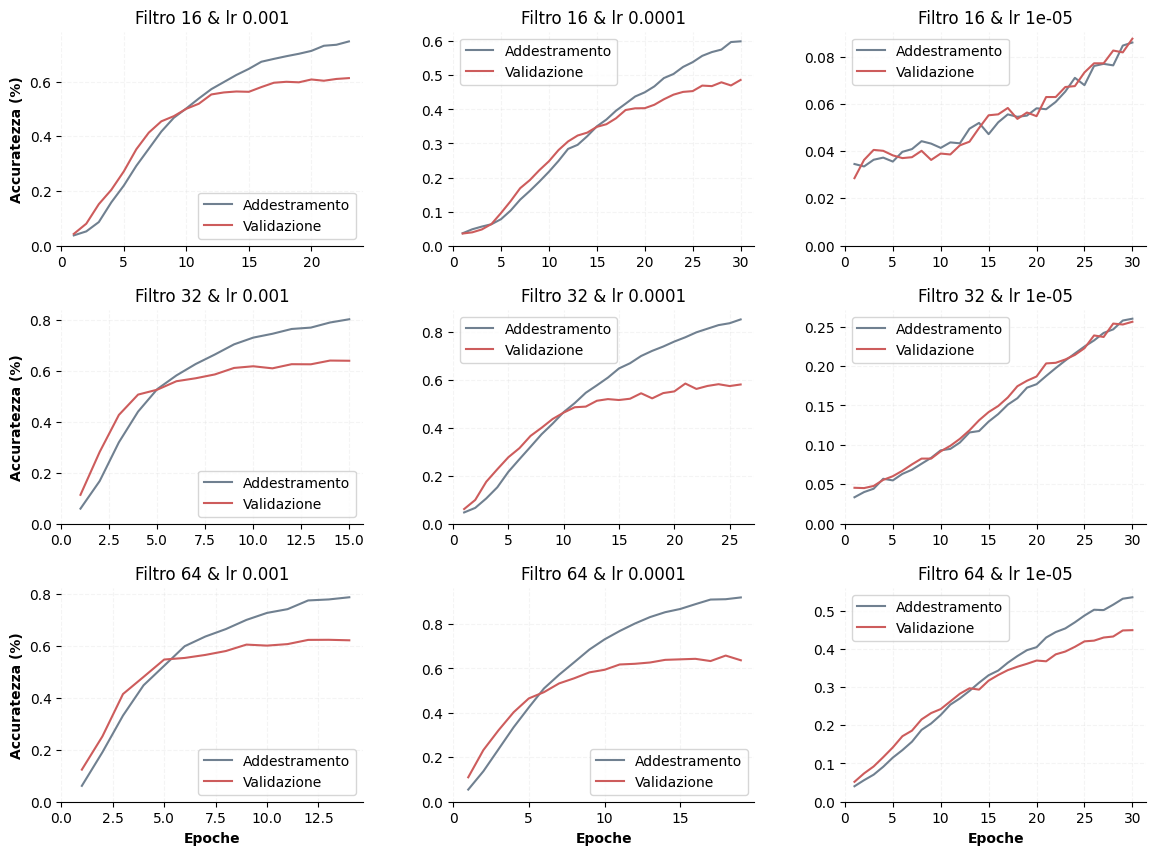

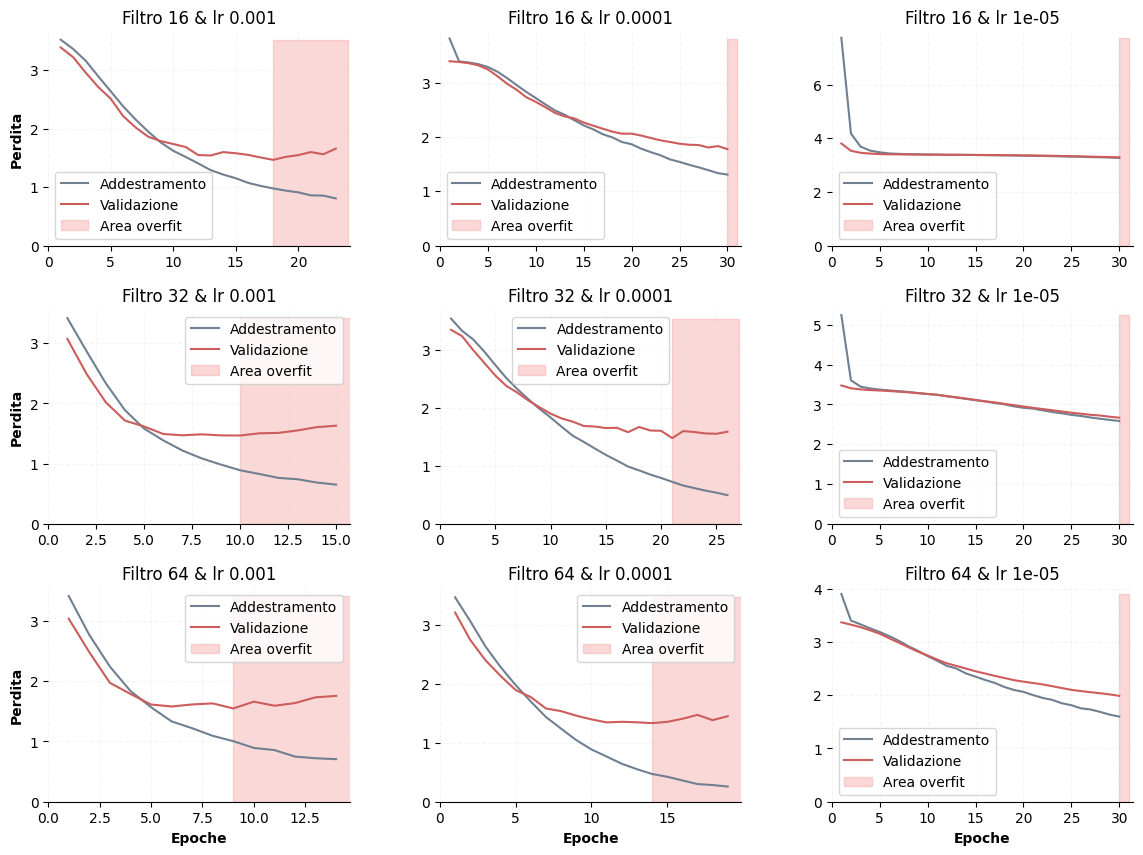

In [83]:
plot_models(path="model_tuning/noise/adam/mfcc", show="accuracy")
plot_models(path="model_tuning/noise/adam/mfcc", show="loss")

Dai grafici emerge che la combinazione più performante è composta da **XX filtri di partenza** e un **tasso di apprendimento di XX**, poiché ritarda maggiormente l'overfitting. Altre combinazioni, come **XX filtri di partenza** e un **tasso di apprendimento di 1e-5**, mostrano buone prestazioni ma anche un inizio di overfitting, evidenziato dallo distaccamento tra la perdita di addestramento e quella di validazione.

Procediamo quindi con l'addestramento del modello con **XX filtri di partenza** e un **tasso di apprendimento di XX**. Come di consueto, salviamo i risultati in un file `keras` e la cronologia (history) in un file `csv`. Infine, convertiamo il file in formato `onnx`.

In [ ]:
for audio, label in mfcc_mixed_train_ds:
    tuned_improved_basic_model = get_improved_basic_model(audio.shape[1:])
    
tuned_improved_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=AGGIUNGERE), metrics=["accuracy"])

tuned_improved_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/noise/adam/mfcc/tuned_improved_basic_model_mfcc.keras", save_best_only=True, monitor="val_loss")]
tuned_improved_history = tuned_improved_basic_model.fit(mfcc_mixed_train_ds, epochs=100, validation_data=mfcc_mixed_val_ds, callbacks=tuned_improved_basic_model_callbacks)

In [ ]:
tuned_improved_history_df = convert_history_to_csv(tuned_improved_history)
tuned_improved_history_df.to_csv("model_histories/noise/adam/mfcc/tuned_improved_history_mfcc.csv")

convert_model_to_onnx("bestmodels/noise/adam/mfcc/tuned_improved_basic_model_mfcc.keras", (98, 12, 1))

In [ ]:
create_train_val_plot(tuned_improved_history.history)

In [ ]:
tuned_improved_best_model = tf.keras.models.load_model("bestmodels/noise/adam/mfcc/tuned_improved_basic_model_mfcc.keras")
test_loss, test_acc = tuned_improved_best_model.evaluate(mfcc_mixed_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

In [ ]:
evaluate_onnx_model("bestmodels/noise/adam/mfcc/tuned_improved_basic_model_mfcc.onnx", mfcc_mixed_test_ds)

AGGIUNGERE COMMENTO SU COME SI E' AGGIORNATO. L'accuratezza è attualmente **XX%**.

In [ ]:
for audio, label in mfcc_mixed_test_ds:
    create_distribution_plot(tuned_improved_best_model, audio, label)
    break

### Miglioramenti all'architettura del modello
Procediamo quindi con la fase corrispettiva al notebook di riferimento.

In [76]:
def bp_basic_model():
    # input e pre processamento
    inputs = tf.keras.Input(shape=(98, 12, 1))
    
    x = residual_block(inputs, 32, pooling=True)
    x = residual_block(x, 64, pooling=True)
    x = residual_block(x, 128, pooling=True)
    x = residual_block(x, 256, pooling=True)
    x = residual_block(x, 256, pooling=False)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Livelli per la classificazione
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [77]:
bp_basic_model = bp_basic_model()
bp_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

bp_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/noise/adam/mfcc/bp_basic_model_mfcc.keras", save_best_only=True, monitor="val_loss")]
bp_model_history = bp_basic_model.fit(mfcc_mixed_train_ds, epochs=100, validation_data=mfcc_mixed_val_ds, callbacks=bp_basic_model_callbacks)

Epoch 1/100
243/243 [==============================] - 2s 6ms/step - loss: 5.2090 - accuracy: 0.0521 - val_loss: 3.4368 - val_accuracy: 0.0883
Epoch 2/100
243/243 [==============================] - 1s 5ms/step - loss: 3.4367 - accuracy: 0.0970 - val_loss: 3.2160 - val_accuracy: 0.1223
Epoch 3/100
243/243 [==============================] - 1s 5ms/step - loss: 3.1663 - accuracy: 0.1347 - val_loss: 3.0941 - val_accuracy: 0.1462
Epoch 4/100
243/243 [==============================] - 1s 5ms/step - loss: 2.9698 - accuracy: 0.1710 - val_loss: 2.8425 - val_accuracy: 0.1898
Epoch 5/100
243/243 [==============================] - 1s 5ms/step - loss: 2.7695 - accuracy: 0.2164 - val_loss: 2.8219 - val_accuracy: 0.1906
Epoch 6/100
243/243 [==============================] - 1s 5ms/step - loss: 2.5888 - accuracy: 0.2622 - val_loss: 3.0888 - val_accuracy: 0.2122
Epoch 7/100
243/243 [==============================] - 1s 5ms/step - loss: 2.4374 - accuracy: 0.2972 - val_loss: 2.9680 - val_accuracy: 0.2388

Salviamo nuovamente la history del modello in un file csv e convertiamo il miglior modello nel formato **.onnx**.

In [78]:
bp_model_history_df = convert_history_to_csv(bp_model_history)
bp_model_history_df.to_csv("model_histories/noise/adam/mfcc/bp_model_history_mfcc.csv")

convert_model_to_onnx("bestmodels/noise/adam/mfcc/bp_basic_model_mfcc.keras", (98, 12, 1))

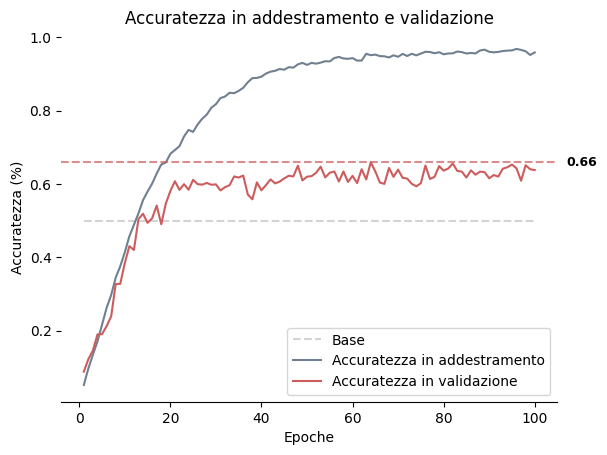

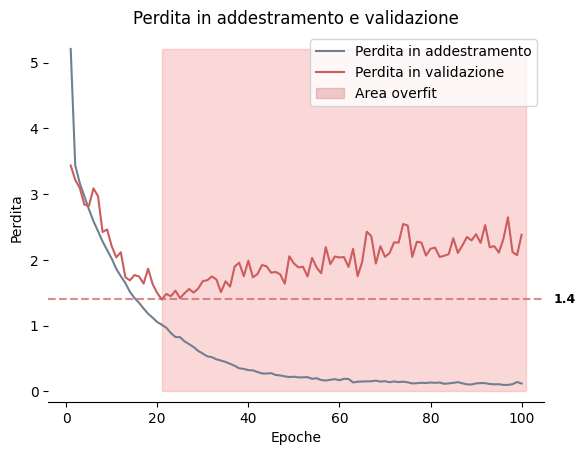

In [79]:
create_train_val_plot(bp_model_history.history)

In questo caso il modello **HA raggiunto una fase di overfitting**, inoltre le prestazioni sono diminuite di parecchio sotto qualsiasi aspetto.

In [80]:
best_bp_basic_model = tf.keras.models.load_model("bestmodels/noise/adam/mfcc/bp_basic_model_mfcc.keras")
test_loss, test_acc = best_bp_basic_model.evaluate(mfcc_mixed_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 0s 2ms/step - loss: 1.3730 - accuracy: 0.5967
Accuratezza: 0.597


In [81]:
evaluate_onnx_model("bestmodels/noise/adam/mfcc/bp_basic_model_mfcc.onnx", mfcc_mixed_test_ds)

Accuratezza: 0.597


Abbiamo ottenuto un forte peggioramento per quanto riguarda l'accuratezza, ottenendo un **62.1%**.

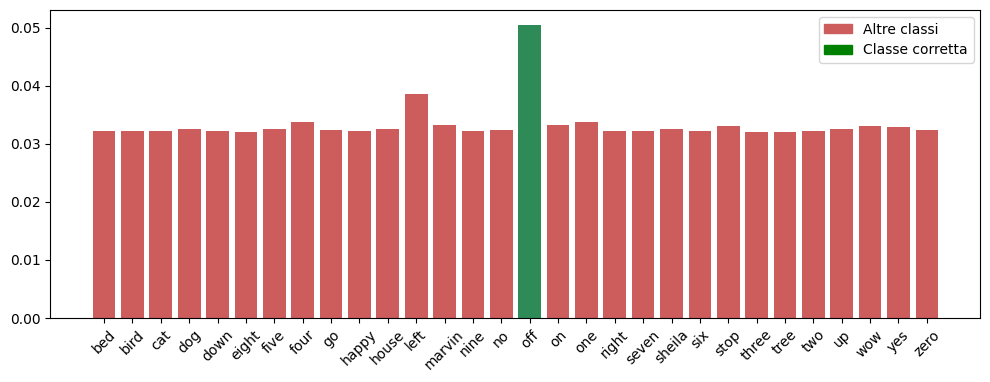

In [82]:
for audio, label in mfcc_mixed_test_ds:
    create_distribution_plot(best_bp_basic_model, audio, label)
    break